<a id='top'></a>
# Table of Contents:  
1) [Loading Capital Bikeshare Data](#capitalbikeshare)  
2) [Loading Live XML Feed Data](#xmlfeed)  
3) [Combine Capital Bikeshare and Live XML](#combine)  
4) [Explore the Capital Bikeshare and Live XML Combined Dataset](#explore1)  
5) [Loading CaBi Tracker Data](#cabitracker)  
6) [Create Full Baseline Dataset](#fullbaseline)  
7) [General Data Exploration for Full Baseline](#explore2)  
8) [Station Forecasts](#forecast)

In [1]:
import os
import re
import pandas as pd
import numpy as np
import urllib.request
import shutil
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.dates as md
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

pandas2ri.activate()
ts = robjects.r('ts')
forecast = importr('forecast')
sns.set_style("whitegrid")
%matplotlib inline
pd.options.mode.chained_assignment = None

<a id='capitalbikeshare'></a>
# Load in Capital Bikeshare's Historical Trip Pattern Data
[Back to Top](#top)

To begin, I will read in the most recent, historical year of data available from Capital Bikeshare. This ranges from 2015 Q3 to 2016 Q3. Each file is stored as a separate dataframe so that I can explore each one individually before combining them into one dataframe.

In [2]:
os.chdir('/Users/WhoaaaItsDavid/Desktop/Springboard/Bike_Share')
df_2015Q3 = pd.read_csv('data/2015-Q3-cabi-trip-history-data.csv')
df_2015Q4 = pd.read_csv('data/2015-Q4-Trips-History-Data.csv')
df_2016Q1 = pd.read_csv('data/2016-Q1-Trips-History-Data.csv')
df_2016Q2 = pd.read_csv('data/2016-Q2-Trips-History-Data.csv')
df_2016Q3_1 = pd.read_csv('data/2016-Q3-Trips-History-Data-1.csv')
df_2016Q3_2 = pd.read_csv('data/2016-Q3-Trips-History-Data-2.csv')

Below I explore each dataframe so that I can determine whether or not they will combine easily.

In [3]:
df_2015Q3.info()
df_2015Q3.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056366 entries, 0 to 1056365
Data columns (total 9 columns):
Duration (ms)           1056366 non-null int64
Start date              1056366 non-null object
End date                1056366 non-null object
Start station number    1056366 non-null int64
Start station           1056366 non-null object
End station number      1056366 non-null int64
End station             1056366 non-null object
Bike #                  1056366 non-null object
Member type             1056366 non-null object
dtypes: int64(3), object(6)
memory usage: 72.5+ MB


,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike #,Member type
0,257866,7/1/2015 0:00,7/1/2015 0:04,31116,California St & Florida Ave NW,31117,15th & Euclid St NW,W21516,Registered
1,2683934,7/1/2015 0:00,7/1/2015 0:45,31247,Jefferson Dr & 14th St SW,31247,Jefferson Dr & 14th St SW,W00476,Casual


In [4]:
df_2015Q4.info()
df_2015Q4.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706004 entries, 0 to 706003
Data columns (total 9 columns):
Duration (ms)           706004 non-null int64
Start date              706004 non-null object
End date                706004 non-null object
Start station number    706004 non-null int64
Start station           706004 non-null object
End station number      706004 non-null int64
End station             706004 non-null object
Bike #                  706004 non-null object
Member type             706004 non-null object
dtypes: int64(3), object(6)
memory usage: 48.5+ MB


,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike #,Member type
0,166050,10/1/2015 0:01,10/1/2015 0:04,31602,Park Rd & Holmead Pl NW,31105,14th & Harvard St NW,W21109,Registered
1,379172,10/1/2015 0:01,10/1/2015 0:07,31314,34th & Water St NW,31237,25th St & Pennsylvania Ave NW,W20603,Registered


In [5]:
df_2016Q1.info()
df_2016Q1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552399 entries, 0 to 552398
Data columns (total 9 columns):
Duration (ms)           552399 non-null int64
Start date              552399 non-null object
End date                552399 non-null object
Start station number    552399 non-null int64
Start station           552399 non-null object
End station number      552399 non-null int64
End station             552399 non-null object
Bike number             552399 non-null object
Member Type             552399 non-null object
dtypes: int64(3), object(6)
memory usage: 37.9+ MB


,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type
0,301295,3/31/2016 23:59,4/1/2016 0:04,31280,11th & S St NW,31506,1st & Rhode Island Ave NW,W00022,Registered
1,557887,3/31/2016 23:59,4/1/2016 0:08,31275,New Hampshire Ave & 24th St NW,31114,18th St & Wyoming Ave NW,W01294,Registered


In [6]:
df_2016Q2.info()
df_2016Q2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942332 entries, 0 to 942331
Data columns (total 9 columns):
Duration (ms)           942332 non-null int64
Start date              942332 non-null object
End date                942332 non-null object
Start station number    942332 non-null int64
Start station           942332 non-null object
End station number      942332 non-null int64
End station             942332 non-null object
Bike number             942332 non-null object
Account type            942332 non-null object
dtypes: int64(3), object(6)
memory usage: 64.7+ MB


,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Account type
0,844108,4/1/2016 0:00,4/1/2016 0:14,31247,Jefferson Dr & 14th St SW,31623,Columbus Circle / Union Station,W20351,Casual
1,149995,4/1/2016 0:00,4/1/2016 0:02,31267,17th St & Massachusetts Ave NW,31214,17th & Corcoran St NW,W00443,Registered


In [7]:
df_2016Q3_1.info()
df_2016Q3_1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723741 entries, 0 to 723740
Data columns (total 9 columns):
Duration (ms)           723741 non-null int64
Start date              723741 non-null object
End date                723741 non-null object
Start station number    723741 non-null int64
Start station           723741 non-null object
End station number      723741 non-null int64
End station             723741 non-null object
Bike number             723741 non-null object
Member Type             723741 non-null object
dtypes: int64(3), object(6)
memory usage: 49.7+ MB


,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type
0,840866,8/31/2016 23:59,9/1/2016 0:13,31117,15th & Euclid St NW,31228,8th & H St NW,W20409,Registered
1,656098,8/31/2016 23:58,9/1/2016 0:09,31279,19th & G St NW,31600,5th & K St NW,W20756,Registered


In [8]:
df_2016Q3_2.info()
df_2016Q3_2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344246 entries, 0 to 344245
Data columns (total 9 columns):
Duration (ms)           344246 non-null int64
Start date              344246 non-null object
End date                344246 non-null object
Start station number    344246 non-null int64
Start station           344246 non-null object
End station number      344246 non-null int64
End station             344246 non-null object
Bike number             344246 non-null object
Member Type             344246 non-null object
dtypes: int64(3), object(6)
memory usage: 23.6+ MB


,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type
0,492483,9/30/2016 23:59,10/1/2016 0:07,31047,Braddock Rd Metro,31086,Mount Vernon Ave & E Del Ray Ave,W20904,Registered
1,233489,9/30/2016 23:58,10/1/2016 0:02,31021,Clarendon Blvd & N Fillmore St,31028,N Veitch & Key Blvd,W22741,Registered


Since all dataframes seem to have similar information and data types, and have been created under the same standards through Capital Bikeshare, I will go ahead and standardize each dataframe's feature names. I will then combine all dataframes into one.

In [9]:
new_feature_names = ['Duration', 'Start_Date', 'End_Date', 'Start_Station_Number', 
                     'Start_Station', 'End_Station_Number', 'End_Station', 'Bike_Number', 
                     'Member_Type']

df_2015Q3.columns = new_feature_names
df_2015Q4.columns = new_feature_names
df_2016Q1.columns = new_feature_names
df_2016Q2.columns = new_feature_names
df_2016Q3_1.columns = new_feature_names
df_2016Q3_2.columns = new_feature_names

bike_data = df_2015Q3.append([df_2015Q4, df_2016Q1, df_2016Q2, df_2016Q3_1, df_2016Q3_2])
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4325088 entries, 0 to 344245
Data columns (total 9 columns):
Duration                int64
Start_Date              object
End_Date                object
Start_Station_Number    int64
Start_Station           object
End_Station_Number      int64
End_Station             object
Bike_Number             object
Member_Type             object
dtypes: int64(3), object(6)
memory usage: 330.0+ MB


In [10]:
# Explore the first several rows of the new dataframe
bike_data.head()

,Duration,Start_Date,End_Date,Start_Station_Number,Start_Station,End_Station_Number,End_Station,Bike_Number,Member_Type
0,257866,7/1/2015 0:00,7/1/2015 0:04,31116,California St & Florida Ave NW,31117,15th & Euclid St NW,W21516,Registered
1,2683934,7/1/2015 0:00,7/1/2015 0:45,31247,Jefferson Dr & 14th St SW,31247,Jefferson Dr & 14th St SW,W00476,Casual
2,2349547,7/1/2015 0:02,7/1/2015 0:41,31247,Jefferson Dr & 14th St SW,31247,Jefferson Dr & 14th St SW,W20384,Casual
3,826571,7/1/2015 0:02,7/1/2015 0:16,31229,New Hampshire Ave & T St NW,31602,Park Rd & Holmead Pl NW,W00972,Registered
4,123046,7/1/2015 0:04,7/1/2015 0:06,31610,Eastern Market / 7th & North Carolina Ave SE,31269,3rd St & Pennsylvania Ave SE,W21565,Registered


<a id='xmlfeed'></a>
# Load in a snapshot of Capital Bikeshare's Live XML Feed
Next, I will take a snapshot of the current state of Capital Bikeshare's stations through the Live XML Feed. I will need the latitude and longitude for visualization purposes, and I will need the station capacity for analysis later:  
[Back to Top](#top)

In [11]:
# The code in this cell is from the page 
# [https://kwkelly.com/blog/analyzing-capital-bikeshare-data-with-python-and-pandas/]

# Access the XML feed and download to a file
#def get_station_xml():
#    url = "https://www.capitalbikeshare.com/data/stations/bikeStations.xml"
#    download_dir = 'xml_data'
#    if not os.path.exists(download_dir):
#        os.mkdir(download_dir)
#    file_name = os.path.join(download_dir, 'bike_stations.xml')
#    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
#        shutil.copyfileobj(response, out_file)
#get_station_xml()

# Parse the XML file and return a dataframe object
def xml_to_pandas(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    l = []
    for station in root:
        d = {}
        for attrib in station:
            d[str(attrib.tag)] = str(attrib.text)
        l.append(d)

    df = pd.DataFrame.from_dict(l)
    return df 
bike_stations = xml_to_pandas('xml_data/bike_stations.xml')

 
# Wrangle the resulting dataframe object and display
bike_stations['terminalName'] = bike_stations['terminalName'].astype(int)
bike_stations['lat'] = bike_stations['lat'].astype(float)
bike_stations['long'] = bike_stations['long'].astype(float)
station_locations = bike_stations[['terminalName']]
station_locations['location'] = list(zip(bike_stations['lat'], bike_stations['long']))
station_locations['Station_Capacity'] = (bike_stations['nbBikes'].astype(int) 
                                         + bike_stations['nbEmptyDocks'].astype(int))
station_locations.head()

,terminalName,location,Station_Capacity
0,31000,"(38.858971, -77.05323)",14
1,31001,"(38.85725, -77.05332)",11
2,31002,"(38.856425, -77.049232)",15
3,31003,"(38.86017, -77.049593)",11
4,31004,"(38.857866, -77.05949)",11


<a id='combine'></a>
# Combine the two datasets:
1) Capital Bikeshare's Historical Trip Data stored in bike_data  
2) Capital Bikeshare's Live XML Feed stored in station_locations  
[Back to Top](#top)

In [12]:
# Combine original dataframe with new station lat/long data
# using a left join on End Station and then Start Station
station_locations.columns = ['End_Station_Number', 'End_Location', 'End_Station_Capacity']
bike_data = pd.merge(bike_data, station_locations, how='left', on='End_Station_Number')

station_locations.columns = ['Start_Station_Number', 'Start_Location', 'Start_Station_Capacity']
bike_data = pd.merge(bike_data, station_locations, how='left', on='Start_Station_Number')

# Display the first several rows of the new dataframe
bike_data.head()

,Duration,Start_Date,End_Date,Start_Station_Number,Start_Station,End_Station_Number,End_Station,Bike_Number,Member_Type,End_Location,End_Station_Capacity,Start_Location,Start_Station_Capacity
0,257866,7/1/2015 0:00,7/1/2015 0:04,31116,California St & Florida Ave NW,31117,15th & Euclid St NW,W21516,Registered,"(38.92333, -77.0352)",15.0,"(38.917761, -77.04062)",19.0
1,2683934,7/1/2015 0:00,7/1/2015 0:45,31247,Jefferson Dr & 14th St SW,31247,Jefferson Dr & 14th St SW,W00476,Casual,"(38.888553, -77.032429)",21.0,"(38.888553, -77.032429)",21.0
2,2349547,7/1/2015 0:02,7/1/2015 0:41,31247,Jefferson Dr & 14th St SW,31247,Jefferson Dr & 14th St SW,W20384,Casual,"(38.888553, -77.032429)",21.0,"(38.888553, -77.032429)",21.0
3,826571,7/1/2015 0:02,7/1/2015 0:16,31229,New Hampshire Ave & T St NW,31602,Park Rd & Holmead Pl NW,W00972,Registered,"(38.9308, -77.0315)",19.0,"(38.91554, -77.03818)",23.0
4,123046,7/1/2015 0:04,7/1/2015 0:06,31610,Eastern Market / 7th & North Carolina Ave SE,31269,3rd St & Pennsylvania Ave SE,W21565,Registered,"(38.887378, -77.001955)",14.0,"(38.886952, -76.996806)",14.0


<a id='explore1'></a>
# Explore the new, combined dataframe for inconsistencies:
[Back to Top](#top)

In [13]:
# Determine whether there are any missing values
print('Missing values:')
for feature in bike_data.columns:
    print(feature + ':', bike_data[feature].isnull().values.ravel().sum())

Missing values:
Duration: 0
Start_Date: 0
End_Date: 0
Start_Station_Number: 0
Start_Station: 0
End_Station_Number: 0
End_Station: 0
Bike_Number: 0
Member_Type: 0
End_Location: 76
End_Station_Capacity: 76
Start_Location: 87
Start_Station_Capacity: 87


Seeing as the newly formed features, Start_Location, End_Location, Start_Station_Capacity, and End_Station_Capacity contain missing values I need to determine which stations are missing entries, and why this might be the case.

In [14]:
# Print out unique station numbers to check which 
# stations do not have associated locations or capacities  
start_subset_test = bike_data[bike_data['Start_Location'].isnull()]
print('Start Stations without locations:', start_subset_test['Start_Station_Number'].unique())
start_subset_test = bike_data[bike_data['Start_Station_Capacity'].isnull()]
print('Start Stations without capacities:', start_subset_test['Start_Station_Number'].unique())

end_subset_test = bike_data[bike_data['End_Location'].isnull()]
print('End Stations without locations:', end_subset_test['End_Station_Number'].unique())
end_subset_test = bike_data[bike_data['End_Station_Capacity'].isnull()]
print('End Stations without capacities:', end_subset_test['End_Station_Number'].unique())

Start Stations without locations: [31709]
Start Stations without capacities: [31709]
End Stations without locations: [31709]
End Stations without capacities: [31709]


It is now more clear that station 31709 is the only station that is missing coordinate and capacity data as found using the live XML feed. Doing some research has shown me that it is possible that this station is no longer in service because it is probably an old station that was phased out. I was able to find the coordinates of (38.884085, -76.957461) and capacity of 11 (https://gist.github.com/since1968/e51c0f3d95e67bf49f74). The live XML feed was not able to give me this data because it is a point in time feed whereas the data I am using is from 2015 Q3 - 2016 Q3. I will now add these values to the dataframe.

In [15]:
location_31709 = '(38.884085, -76.957461)'
capacity_31709 = 11
bike_data.loc[bike_data['Start_Station_Number'] == 31709, 'Start_Location'] = \
    location_31709
bike_data.loc[bike_data['Start_Station_Number'] == 31709, 'Start_Station_Capacity'] = \
    capacity_31709
bike_data.loc[bike_data['End_Station_Number'] == 31709, 'End_Location'] = location_31709
bike_data.loc[bike_data['End_Station_Number'] == 31709, 'End_Station_Capacity'] = capacity_31709

# Are the missing values gone?
print('Missing Start Station Location:', \
      bike_data['Start_Location'].isnull().values.ravel().sum())
print('Missing Start Station Capacity:', \
      bike_data['Start_Station_Capacity'].isnull().values.ravel().sum())
print('Missing End Station Location:', \
      bike_data['End_Location'].isnull().values.ravel().sum())
print('Missing End Station Capacity:', \
      bike_data['End_Station_Capacity'].isnull().values.ravel().sum())

Missing Start Station Location: 0
Missing Start Station Capacity: 0
Missing End Station Location: 0
Missing End Station Capacity: 0


In [16]:
# Determine how many different values each feature can take
print('Number of unique values:')
for feature in bike_data.columns:
    print(feature + ':', len(list(bike_data[feature].unique())))

Number of unique values:
Duration: 1828278
Start_Date: 521665
End_Date: 521874
Start_Station_Number: 407
Start_Station: 415
End_Station_Number: 407
End_Station: 415
Bike_Number: 4364
Member_Type: 2
End_Location: 407
End_Station_Capacity: 28
Start_Location: 407
Start_Station_Capacity: 28


As we can see above, some features have an appropriate number of values while others do not. Duration, Start_Date, End_Date, and Member_Type are as expected. Per Capital Bikeshare's website, there are over 3,700 bikes available at over 440 stations. Given this information, the number of unique Bike_Number's may be too high, but this could be a function of changing bike numbers over the course of the year. Lastly, it is odd that Start_Station_Number, Start_Location, End_Station_Number, and End_Location have 407 values while Start_Station and End_Station have 415 values. Since I would have expected these features to match, I will explore and clean further below.

In [17]:
# Split the original data into a dataframe that shows only the start station information
start_df = pd.DataFrame(bike_data['Start_Station'].value_counts())
start_df.reset_index(drop=False, inplace=True)
start_df.columns = ['Start_Station', 'Counts']
start_df = start_df.merge(bike_data[['Start_Location', 'Start_Station_Number', 'Start_Station']], 
                          how='left', on='Start_Station')
start_df.drop_duplicates(inplace=True)
start_df['Start_Location_Lat'] = \
    start_df['Start_Location'].map(lambda x: str(x).split(', ')[0].lstrip('('))
start_df['Start_Location_Long'] = \
    start_df['Start_Location'].map(lambda x: str(x).split(', ')[1].rstrip(')'))
start_df.drop('Start_Location', axis=1, inplace=True)
start_df = start_df.sort_values(by='Start_Station_Number')
start_df.reset_index(drop=True, inplace=True)

start_df.head()

,Start_Station,Counts,Start_Station_Number,Start_Location_Lat,Start_Location_Long
0,20th & Bell St,1371,31000,38.858970999999997,-77.053229999999999
1,Eads St & 15th St S,1298,31000,38.858970999999997,-77.053229999999999
2,18th & Eads St.,3370,31001,38.857250000000001,-77.053319999999999
3,20th & Crystal Dr,7792,31002,38.856425000000002,-77.049232000000003
4,15th & Crystal Dr,7359,31003,38.860169999999997,-77.049593000000002


In [18]:
# Split the original data into a dataframe that shows only the end station information
end_df = pd.DataFrame(bike_data['End_Station'].value_counts())
end_df.reset_index(drop=False, inplace=True)
end_df.columns = ['End_Station', 'Counts']
end_df = end_df.merge(bike_data[['End_Location', 'End_Station_Number', 'End_Station']], 
                      how='left', on='End_Station')
end_df.drop_duplicates(inplace=True)
end_df['End_Location_Lat'] = \
    end_df['End_Location'].map(lambda x: str(x).split(', ')[0].lstrip('('))
end_df['End_Location_Long'] = \
    end_df['End_Location'].map(lambda x: str(x).split(', ')[1].rstrip(')'))
end_df.drop('End_Location', axis=1, inplace=True)
end_df = end_df.sort_values(by='End_Station_Number')
end_df.reset_index(drop=True, inplace=True)

end_df.head()

,End_Station,Counts,End_Station_Number,End_Location_Lat,End_Location_Long
0,Eads St & 15th St S,1352,31000,38.858970999999997,-77.053229999999999
1,20th & Bell St,837,31000,38.858970999999997,-77.053229999999999
2,18th & Eads St.,3205,31001,38.857250000000001,-77.053319999999999
3,20th & Crystal Dr,8797,31002,38.856425000000002,-77.049232000000003
4,15th & Crystal Dr,7495,31003,38.860169999999997,-77.049593000000002


In [19]:
# Print out descriptive stats to check if the same problems persist
print('Unique Start Station Lat/Long:', len(list(bike_data['Start_Location'].unique())))
print('Unique Start Station Numbers:', len(list(start_df['Start_Station_Number'].unique())))
print('Unique Start Station Names:', len(list(start_df['Start_Station'].unique())))
print('Unique End Station Lat/Long:', len(list(bike_data['End_Location'].unique())))
print('Unique End Station Numbers:', len(list(end_df['End_Station_Number'].unique())))
print('Unique End Station Names:', len(list(end_df['End_Station'].unique())))

Unique Start Station Lat/Long: 407
Unique Start Station Numbers: 407
Unique Start Station Names: 415
Unique End Station Lat/Long: 407
Unique End Station Numbers: 407
Unique End Station Names: 415


In [20]:
# Determine where exactly there are issues in the start dataframe
for row in start_df.itertuples():
    try:
        if start_df.get_value(row[0], 'Start_Station_Number') == \
            start_df.get_value(row[0]-1, 'Start_Station_Number'):
            print('Start_Station_Number:', start_df.get_value(row[0]-1, 'Start_Station_Number'), 
                  '\nStart_Station Name:', start_df.get_value(row[0]-1, 'Start_Station'), 
                  '\nName Count:', start_df.get_value(row[0]-1, 'Counts'),
                  'Lat:', start_df.get_value(row[0]-1, 'Start_Location_Lat'),
                  'Long:', start_df.get_value(row[0]-1, 'Start_Location_Long'))
            print('Start_Station_Number:', start_df.get_value(row[0], 'Start_Station_Number'), 
                  '\nStart_Station Name:', start_df.get_value(row[0], 'Start_Station'), 
                  '\nName Count:', start_df.get_value(row[0], 'Counts'),
                  'Lat:', start_df.get_value(row[0], 'Start_Location_Lat'),
                  'Long:', start_df.get_value(row[0], 'Start_Location_Long'), end='\n\n')
    except:
        pass

Start_Station_Number: 31000 
Start_Station Name: 20th & Bell St 
Name Count: 1371 Lat: 38.858970999999997 Long: -77.053229999999999
Start_Station_Number: 31000 
Start_Station Name: Eads St & 15th St S 
Name Count: 1298 Lat: 38.858970999999997 Long: -77.053229999999999

Start_Station_Number: 31030 
Start_Station Name: Lee Hwy & N Adams St 
Name Count: 4621 Lat: 38.89593 Long: -77.089005999999998
Start_Station_Number: 31030 
Start_Station Name: N Adams St & Lee Hwy 
Name Count: 1648 Lat: 38.89593 Long: -77.089005999999998

Start_Station_Number: 31039 
Start_Station Name: N Quincy St & Wilson Blvd 
Name Count: 4791 Lat: 38.880012000000001 Long: -77.107854000000003
Start_Station_Number: 31039 
Start_Station Name: Wilson Blvd & N Quincy St 
Name Count: 1527 Lat: 38.880012000000001 Long: -77.107854000000003

Start_Station_Number: 31048 
Start_Station Name: King St Metro 
Name Count: 2134 Lat: 38.805767000000003 Long: -77.060720000000003
Start_Station_Number: 31048 
Start_Station Name: King S

In [21]:
# Determine where exactly there are issues in the end dataframe
for row in end_df.itertuples():
    try:
        if end_df.get_value(row[0], 'End_Station_Number') == \
            end_df.get_value(row[0]-1, 'End_Station_Number'):
            print('End_Station_Number:', end_df.get_value(row[0]-1, 'End_Station_Number'), 
                  '\nEnd_Station Name:', end_df.get_value(row[0]-1, 'End_Station'), 
                  '\nName Count:', end_df.get_value(row[0]-1, 'Counts'),
                  'Lat:', end_df.get_value(row[0]-1, 'End_Location_Lat'),
                  'Long:', end_df.get_value(row[0]-1, 'End_Location_Long'))
            print('End_Station_Number:', end_df.get_value(row[0], 'End_Station_Number'), 
                  '\nEnd_Station Name:', end_df.get_value(row[0], 'End_Station'), 
                  '\nName Count:', end_df.get_value(row[0], 'Counts'),
                  'Lat:', end_df.get_value(row[0], 'End_Location_Lat'),
                  'Long:', end_df.get_value(row[0], 'End_Location_Long'), end='\n\n')
    except:
        pass

End_Station_Number: 31000 
End_Station Name: Eads St & 15th St S 
Name Count: 1352 Lat: 38.858970999999997 Long: -77.053229999999999
End_Station_Number: 31000 
End_Station Name: 20th & Bell St 
Name Count: 837 Lat: 38.858970999999997 Long: -77.053229999999999

End_Station_Number: 31030 
End_Station Name: Lee Hwy & N Adams St 
Name Count: 2741 Lat: 38.89593 Long: -77.089005999999998
End_Station_Number: 31030 
End_Station Name: N Adams St & Lee Hwy 
Name Count: 1215 Lat: 38.89593 Long: -77.089005999999998

End_Station_Number: 31039 
End_Station Name: N Quincy St & Wilson Blvd 
Name Count: 4315 Lat: 38.880012000000001 Long: -77.107854000000003
End_Station_Number: 31039 
End_Station Name: Wilson Blvd & N Quincy St 
Name Count: 1363 Lat: 38.880012000000001 Long: -77.107854000000003

End_Station_Number: 31048 
End_Station Name: King St Metro 
Name Count: 1746 Lat: 38.805767000000003 Long: -77.060720000000003
End_Station_Number: 31048 
End_Station Name: King St Metro South 
Name Count: 3186 L

It is clear that, when taking into account both start and end station numbers, the same station numbers and lat/long pairs appear to be repeated. Each station number and lat/long pair above is related to two (in one case three) different station names. Further, the station name counts are not repeated, which indicates that the station numbers are not duplicated, but the station names have been changing over time. For this reason, and because this is a unique identifier that is not predictive, I will drop the Start_Station and End_Station features from the data set.

In [22]:
bike_data.drop(['Start_Station', 'End_Station'], 
                axis=1, inplace=True)

bike_data.head()

,Duration,Start_Date,End_Date,Start_Station_Number,End_Station_Number,Bike_Number,Member_Type,End_Location,End_Station_Capacity,Start_Location,Start_Station_Capacity
0,257866,7/1/2015 0:00,7/1/2015 0:04,31116,31117,W21516,Registered,"(38.92333, -77.0352)",15.0,"(38.917761, -77.04062)",19.0
1,2683934,7/1/2015 0:00,7/1/2015 0:45,31247,31247,W00476,Casual,"(38.888553, -77.032429)",21.0,"(38.888553, -77.032429)",21.0
2,2349547,7/1/2015 0:02,7/1/2015 0:41,31247,31247,W20384,Casual,"(38.888553, -77.032429)",21.0,"(38.888553, -77.032429)",21.0
3,826571,7/1/2015 0:02,7/1/2015 0:16,31229,31602,W00972,Registered,"(38.9308, -77.0315)",19.0,"(38.91554, -77.03818)",23.0
4,123046,7/1/2015 0:04,7/1/2015 0:06,31610,31269,W21565,Registered,"(38.887378, -77.001955)",14.0,"(38.886952, -76.996806)",14.0


To help visualize the popularity of certain stations and trips between all stations, I have further wrangled the data off to the side. The resulting visualizations can be found here:  
  
• Starting Station Popularity Bubble Map:   https://public.tableau.com/profile/dpalbrecht#!/vizhome/CapitalBikeshareStartingStationPopularityBubbleMap2015Q3-2016Q3/Sheet2  
• Total Trip Popularity Spider Map:  
https://public.tableau.com/profile/dpalbrecht#!/vizhome/CapitalBikeshareTotalTripPopularitySpiderMap2015Q3-2016Q3/Sheet1

<a id='cabitracker'></a>
# Load CaBi Tracker's Historical System Outage Data
[Back to Top](#top)

In [23]:
# Read in CaBi Tracker data
outage_data = pd.read_csv('outage/status_07012015_08312015.csv')

# Display outage data
outage_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75219 entries, 0 to 75218
Data columns (total 6 columns):
Terminal Number    75219 non-null int64
Station Name       75219 non-null object
Status             75219 non-null object
Start              75219 non-null object
End                75219 non-null object
Duration           75219 non-null int64
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


In [24]:
# Rename column names
outage_data.columns = ['Station_Number', 'Station_Name',
                      'Status', 'Start', 'End', 'Duration']
outage_data['Start'] = pd.to_datetime(outage_data['Start'], infer_datetime_format=True)
outage_data['End'] = pd.to_datetime(outage_data['End'], infer_datetime_format=True)

# Display the first 5 rows of outage data
outage_data.head()

,Station_Number,Station_Name,Status,Start,End,Duration
0,31631,8th & F St NE,full,2015-08-31 21:02:13,2015-08-31 23:59:34,177
1,31252,21st St & Pennsylvania Ave NW,empty,2015-08-31 21:45:48,2015-08-31 23:58:34,133
2,31247,Jefferson Dr & 14th St SW,empty,2015-08-31 23:55:31,2015-08-31 23:56:32,1
3,31119,14th & Belmont St NW,full,2015-08-31 21:56:58,2015-08-31 23:54:31,118
4,31221,18th & M St NW,empty,2015-08-31 22:19:15,2015-08-31 23:53:30,94


In [25]:
# Take only the first outage notification for each station
outage_data_reduced = pd.DataFrame()
no_outage_list = []
for station in list(bike_data['Start_Station_Number'].unique()): 
    temp_df = outage_data[outage_data['Station_Number'] == station].sort_values(by='Start')
    try:
        outage_data_reduced = outage_data_reduced.append(temp_df.iloc[0])
    except:
        no_outage_list.append(station)
    
print('There is no outage data for {} stations.'.format(len(no_outage_list)))
outage_data_reduced.head()

There is no outage data for 77 stations.


,Duration,End,Start,Station_Name,Station_Number,Status
75075,5.0,2015-07-01 08:25:38,2015-07-01 08:20:33,California St & Florida Ave NW,31116.0,empty
74861,1.0,2015-07-01 10:52:37,2015-07-01 10:51:36,Jefferson Dr & 14th St SW,31247.0,full
75127,9.0,2015-07-01 07:45:04,2015-07-01 07:35:57,New Hampshire Ave & T St NW,31229.0,empty
75016,20.0,2015-07-01 09:02:07,2015-07-01 08:41:50,Eastern Market / 7th & North Carolina Ave SE,31610.0,empty
75201,5.0,2015-07-01 00:48:20,2015-07-01 00:43:16,Lincoln Memorial,31258.0,empty


Since there are stations with no outage data, I need to take these stations out of the bike_data dataframe for two reasons:  
1) I won't be able to accurately determine how many bikes to start with at these stations at time 0  
2) Since these stations do not have any empty/full notifications, they likely do not need rebalancing

In [26]:
# Sanity check before taking stations out
print('{} start stations; {} end stations'\
      .format(len(list(bike_data['Start_Station_Number'].unique())), 
              len(list(bike_data['End_Station_Number'].unique()))))

407 start stations; 407 end stations


In [27]:
# Take out stations that do not have any empty or full notifications
bike_data = bike_data[np.logical_not(bike_data['Start_Station_Number'].isin(no_outage_list))]
bike_data = bike_data[np.logical_not(bike_data['End_Station_Number'].isin(no_outage_list))]

# Take out unecessary features from bike_data and prepare to split
bike_data.drop(['Duration', 'Bike_Number', 'Member_Type', 'Start_Location', 
                'End_Location'], axis=1, inplace=True)
bike_data['Status'] = np.nan
bike_data['Start_Date'] = pd.to_datetime(bike_data['Start_Date'], infer_datetime_format=True)
bike_data['End_Date'] = pd.to_datetime(bike_data['End_Date'], infer_datetime_format=True)

# Display
bike_data.head()

,Start_Date,End_Date,Start_Station_Number,End_Station_Number,End_Station_Capacity,Start_Station_Capacity,Status
0,2015-07-01 00:00:00,2015-07-01 00:04:00,31116,31117,15.0,19.0,NaN
1,2015-07-01 00:00:00,2015-07-01 00:45:00,31247,31247,21.0,21.0,NaN
2,2015-07-01 00:02:00,2015-07-01 00:41:00,31247,31247,21.0,21.0,NaN
3,2015-07-01 00:02:00,2015-07-01 00:16:00,31229,31602,19.0,23.0,NaN
4,2015-07-01 00:04:00,2015-07-01 00:06:00,31610,31269,14.0,14.0,NaN


In [28]:
# Sanity check after taking stations out
print('{} start stations; {} end stations'\
      .format(len(list(bike_data['Start_Station_Number'].unique())), 
              len(list(bike_data['End_Station_Number'].unique()))))

330 start stations; 330 end stations


<a id='fullbaseline'></a>
# Create a baseline for the final, combined dataframe and create target variables
Here I will create two target variables: 1) The number of bikes at a station and 2) the percent capacity at a station. The data I have been wrangling above, in bike_data, is historical trip data, so it is only part of what is needed to back out bikes and percent capacity at each station. I will bring in the second part of the needed data from CaBi Tracker, which shows the points in time that any station starts an empty cycle, ends an empty cycle, starts a full cycle, and ends a full cycle. Merging these two data sets together should guide me in determining the flow of bikes between stations.  
[Back to Top](#top)

In [29]:
discrete_bike_data = pd.DataFrame()

for station in list(bike_data['Start_Station_Number'].unique()): 
    
    # Select subsets of the bike_data and outage_data dataframes
    bike_data_subset = \
        bike_data[(bike_data['Start_Station_Number'] == station) | \
                  (bike_data['End_Station_Number'] == station)]
    outage_data_subset = outage_data_reduced[outage_data_reduced['Station_Number'] == station]
    
    # Split bike_data_subset into a start station dataframe that matches the station
    # The resulting dataframe only includes a 'start date' and an action to subtract a bike
    bike_data_subset_start = \
        bike_data_subset[bike_data_subset['Start_Station_Number'] == station]
    bike_data_subset_start.drop(['End_Date', 'Start_Station_Number', 
                                 'End_Station_Number', 'End_Station_Capacity'], 
                                axis=1, inplace=True)
    bike_data_subset_start['Status'] = 'subtract bike'
    bike_data_subset_start.set_index('Start_Date', drop=False, inplace=True)

    # Split bike_data_subset into a end station dataframe that matches the station
    # The resulting dataframe only includes a 'start date' and an action to add a bike
    bike_data_subset_end = bike_data_subset[bike_data_subset['End_Station_Number'] == station]
    bike_data_subset_end.drop(['Start_Date', 'Start_Station_Number', 
                               'End_Station_Number', 'Start_Station_Capacity'], 
                              axis=1, inplace=True)
    bike_data_subset_end.columns = ['Start_Date', 'Start_Station_Capacity', 'Status']
    bike_data_subset_end['Status'] = 'add bike'
    bike_data_subset_end.set_index('Start_Date', drop=False, inplace=True)
    
    if outage_data_subset.iloc[0].loc['Status'] == 'empty':
        # Split outage_data_subset for when an empty notification starts
        outage_data_subset_status = \
            outage_data_subset.drop(['End', 'Station_Name', 'Duration'], axis=1)
        outage_data_subset_status = \
            outage_data_subset_status[outage_data_subset_status['Status'] == 'empty']
        outage_data_subset_status['Status'] = 'empty'
        outage_data_subset_status.columns = ['Start_Date', 'Station_Number', 'Status']
        outage_data_subset_status['Start_Station_Capacity'] = \
            bike_data_subset_start['Start_Station_Capacity'].iloc[0]
        outage_data_subset_status.set_index('Start_Date', drop=False, inplace=True)

    else:
        # Split outage_data_subset for when a full notification starts
        outage_data_subset_status = \
            outage_data_subset.drop(['End', 'Station_Name', 'Duration'], axis=1)
        outage_data_subset_status = \
            outage_data_subset_status[outage_data_subset_status['Status'] == 'full']
        outage_data_subset_status['Status'] = 'full'
        outage_data_subset_status.columns = ['Start_Date', 'Station_Number', 'Status']
        outage_data_subset_status['Start_Station_Capacity'] = \
            bike_data_subset_start['Start_Station_Capacity'].iloc[0]
        outage_data_subset_status.set_index('Start_Date', drop=False, inplace=True)

    # Combine the discretized dataframes
    combined_subset = \
        bike_data_subset_start.append([bike_data_subset_end, outage_data_subset_status])

    # Prepare the combined dataframe for iteration
    combined_subset['Bike_Count'] = 0
    combined_subset['Station_Number'] = station
    combined_subset.columns = \
        ['Date', 'Start_Station_Capacity', 'Station_Number', 'Status', 'Bike_Count']
    combined_subset.sort_values(by='Date', ascending=True, inplace=True)
    combined_subset.reset_index(drop=True, inplace=True)
    
    # Iterate over the rows in combined_subset and fill in Bike_Count 
    cut = 1
    for row in combined_subset.itertuples():

        if row[4] == 'empty':
            combined_subset.set_value(row[0], 'Bike_Count', 0)
            if cut == 1:
                combined_subset.drop(combined_subset.index[:row[0]], inplace=True)
                cut -= 1

        elif row[4] == 'full':
            combined_subset.set_value(row[0], 'Bike_Count', 
                                      combined_subset['Start_Station_Capacity'].iloc[0])
            if cut == 1:
                combined_subset.drop(combined_subset.index[:row[0]], inplace=True)
                cut -= 1

        elif row[4] == 'add bike':
            try:
                if combined_subset.get_value(row[0]-1, 'Bike_Count') == \
                    combined_subset.get_value(row[0]-1, 'Start_Station_Capacity'):
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count'))
                else:
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count')+1)
            except:
                pass


        elif row[4] == 'subtract bike':
            try:
                if combined_subset.get_value(row[0]-1, 'Bike_Count') == 0:
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count'))
                else:
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count')-1)  
            except:
                pass


    # Add new target feature, Count_Percent_Capacity
    combined_subset['Count_Percent_Capacity'] = \
        (combined_subset['Bike_Count']/combined_subset['Start_Station_Capacity'])*100
    
    # Filter out the outage flag
    combined_subset = \
        combined_subset[(combined_subset['Status'] == 'add bike') | \
                        (combined_subset['Status'] == 'subtract bike')]
    
    # Add this data to the new dataframe
    discrete_bike_data = discrete_bike_data.append(combined_subset)

In [30]:
# How does the combined dataframe look?
discrete_bike_data.head()

,Date,Start_Station_Capacity,Station_Number,Status,Bike_Count,Count_Percent_Capacity
24,2015-07-01 08:25:00,19.0,31116,add bike,1,5.263158
25,2015-07-01 08:26:00,19.0,31116,subtract bike,0,0.000000
26,2015-07-01 09:42:00,19.0,31116,add bike,1,5.263158
27,2015-07-01 09:55:00,19.0,31116,subtract bike,0,0.000000
28,2015-07-01 10:38:00,19.0,31116,add bike,1,5.263158


In [31]:
# Print out dataframe info
discrete_bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8135571 entries, 24 to 2776
Data columns (total 6 columns):
Date                      datetime64[ns]
Start_Station_Capacity    float64
Station_Number            int64
Status                    object
Bike_Count                int64
Count_Percent_Capacity    float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 434.5+ MB


<a id='explore2'></a>
# Data exploration for the combined dataframe
Below I explore the newly combined dataframe:  
[Back to Top](#top)

In [32]:
# How many stations do I have?
print('{} stations'.format(len(list(discrete_bike_data['Station_Number'].unique()))))

330 stations


In [33]:
# Are there any missing values?
for column in discrete_bike_data.columns:
    print(column, ':', len(discrete_bike_data[discrete_bike_data[column].isnull()]))  

Date : 0
Start_Station_Capacity : 0
Station_Number : 0
Status : 0
Bike_Count : 0
Count_Percent_Capacity : 0


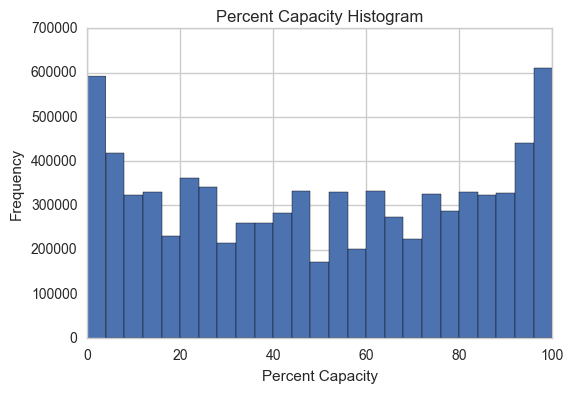

In [34]:
# Look at the distribution of percent capacities for full year of full data for all stations
discrete_bike_data_only = discrete_bike_data.copy()
pd.DataFrame.hist(discrete_bike_data_only, column='Count_Percent_Capacity',
                  bins=25)
plt.xlabel('Percent Capacity')
plt.ylabel('Frequency')
plt.title('Percent Capacity Histogram');

In [35]:
#os.chdir('/Users/WhoaaaItsDavid/Desktop/Springboard/Bike_Share')
#file = open('discrete_bike_data_only.csv', 'w')
#file.write(discrete_bike_data_only['Count_Percent_Capacity'].to_csv())
#file.close()

In [36]:
# What is the range of possible values of percent capacity?
print('Min percent capacity:', min(discrete_bike_data_only['Count_Percent_Capacity']))
print('Max percent capacity:', max(discrete_bike_data_only['Count_Percent_Capacity']))

Min percent capacity: 0.0
Max percent capacity: 100.0


Below I use boxplots to visualize the percent capacity for each station. Every 35 stations are plotted below:

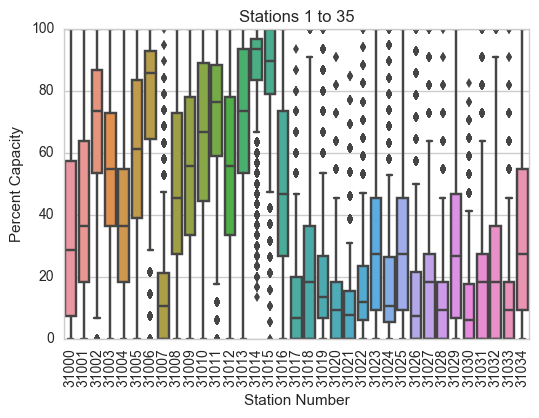

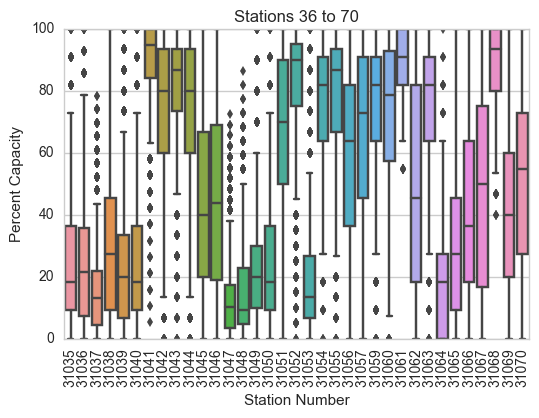

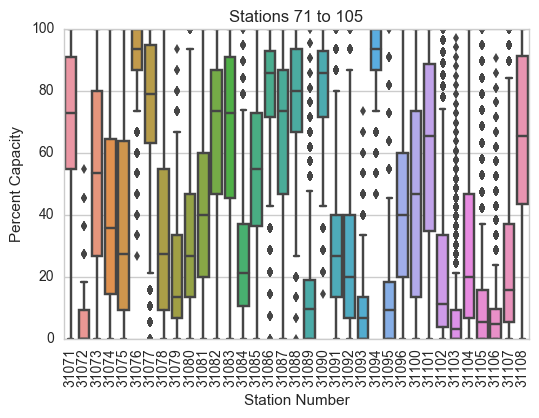

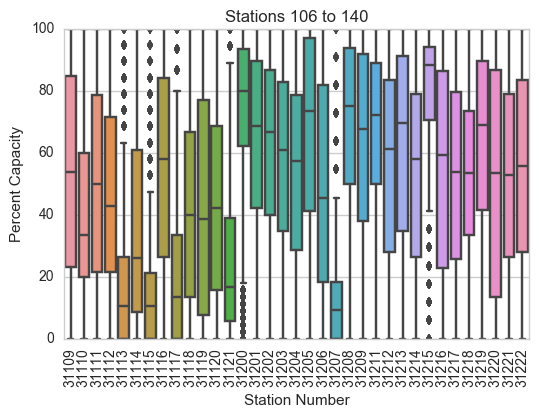

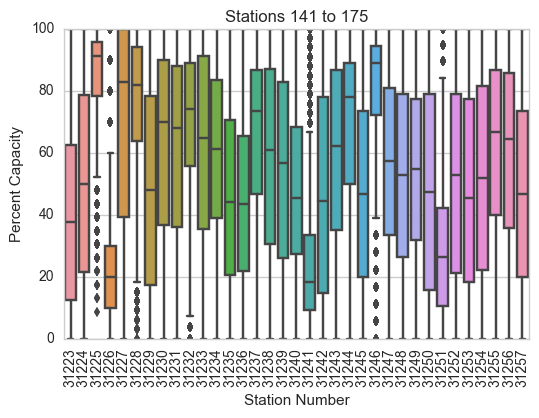

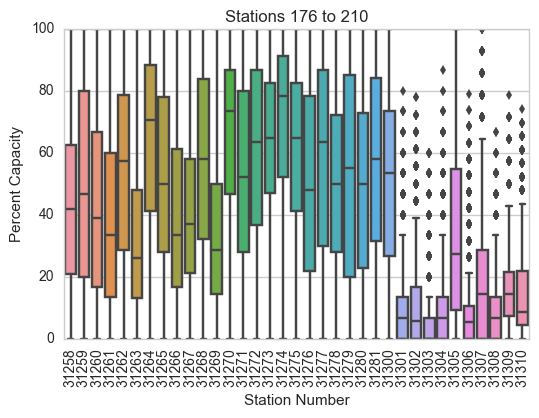

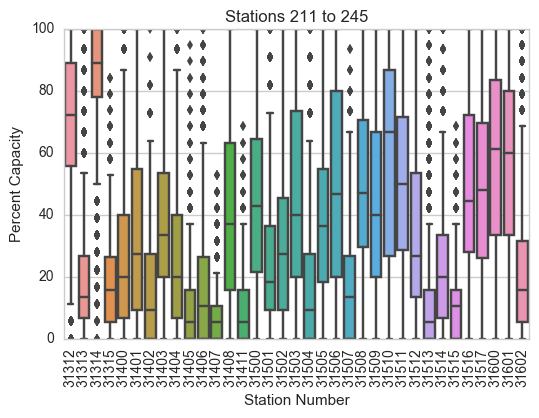

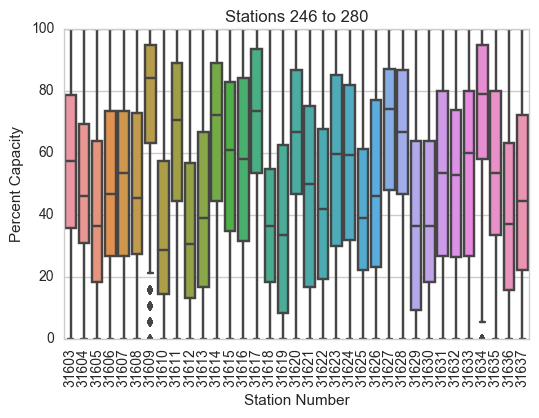

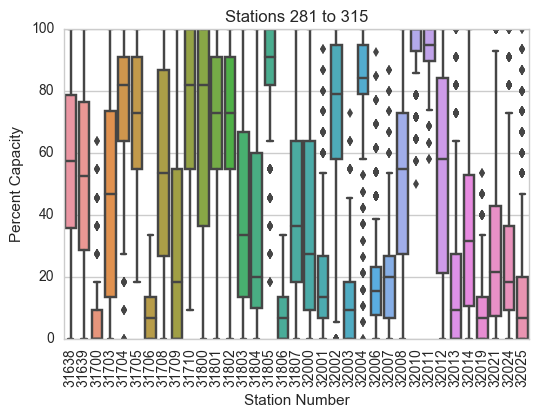

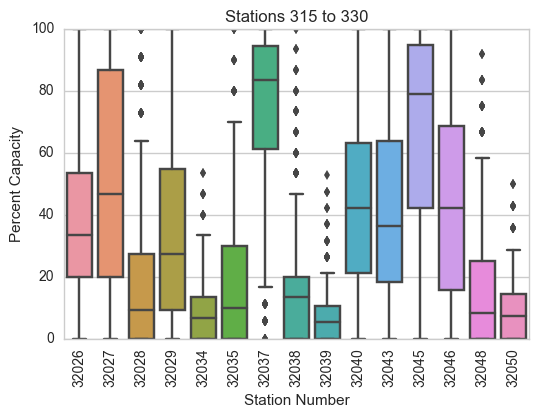

In [37]:
station_numbers = {0:35,35:70,70:105,105:140,140:175,175:210,210:245,245:280,280:315,315:None}

for number in sorted(list(station_numbers.keys())):
    station_list = []
    for station in sorted(list(bike_data['Start_Station_Number'].unique()))\
        [number:station_numbers[number]]:
        station_list.append(int(station))

    discrete_bike_data_filtered = \
        discrete_bike_data_only[discrete_bike_data_only['Station_Number'].isin(station_list)]
    ax = sns.boxplot(x="Station_Number", y="Count_Percent_Capacity", 
                     data=discrete_bike_data_filtered)
    if station_numbers[number] != None:
        plt.title('Stations {} to {}'.format(number+1, station_numbers[number]))
    else:
        plt.title('Stations {} to {}'\
                  .format(number, len(list(discrete_bike_data['Station_Number'].unique()))))
    plt.ylabel('Percent Capacity')
    plt.xlabel('Station Number')
    plt.xticks(rotation=90)
    plt.show();

## Does it make sense to analyze every single station? 
The combined dataframe looks like it is sound. Remembering the detail above when not all stations had outage data (meaning they did not go empty or full over the outage data time period) I wonder whether all stations have enough data for forecasting or whether some stations have longer periods of time without use. I explore and address the following two questions:  
1) Are there stations with less than 90% of the date range of the station with the largest date range?  
2) Are there stations with less than 4 instances per hour per day, on average?

#### 1) Are there stations with less than 90% of the date range of the station with the largest date range?

In [38]:
# Find the number of days for each station
num_days_dict = {}
for station in list(discrete_bike_data_only['Station_Number'].unique()):
    temp_df = discrete_bike_data_only[discrete_bike_data_only['Station_Number'] == station]
    days = int(str(temp_df['Date'].max() - temp_df['Date'].min()).split(' days')[0])
    num_days_dict[station] = days

In [39]:
# Find the stations with less than 90% of the max total days
max_days = max(num_days_dict.values())
too_few_days = {}

for station in list(num_days_dict.keys()):
    if num_days_dict[station] <= max_days*.90:
        too_few_days[station] = num_days_dict[station]
        
# How many stations have less than 90% of the max total days
print('{} stations with less than 90% of the max total days.'\
      .format(len(list(too_few_days.keys()))))

6 stations with less than 90% of the max total days.


In [40]:
# Take discrete_bike_data_only and filter out any stations with too few days
reduced_discrete_bike_data = \
    discrete_bike_data_only[np.logical_not(discrete_bike_data_only['Station_Number']\
        .isin(list(too_few_days.keys())))]

# Did I take out too much data?
reduced_discrete_bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8131333 entries, 24 to 55559
Data columns (total 6 columns):
Date                      datetime64[ns]
Start_Station_Capacity    float64
Station_Number            int64
Status                    object
Bike_Count                int64
Count_Percent_Capacity    float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 434.3+ MB


#### 2) Are there stations with less than 4 instances per hour per day, on average?

In [41]:
# Find the number of instances for each station
reduced_discrete_bike_data_counts = \
    pd.DataFrame(pd.value_counts(reduced_discrete_bike_data['Station_Number']))
reduced_discrete_bike_data_counts.reset_index(drop=False, inplace=True)
reduced_discrete_bike_data_counts.columns=['Station_Number', 'Count']
reduced_discrete_bike_data_counts['Count'] = \
    reduced_discrete_bike_data_counts['Count'].astype(int)

In [42]:
# Find the stations without at least 4 instances per hour per day of data
too_few_instances = {}
for station in list(reduced_discrete_bike_data_counts['Station_Number'].unique()):
    if int(reduced_discrete_bike_data_counts\
           .loc[reduced_discrete_bike_data_counts['Station_Number'] == station, 'Count']\
               .item()) < int((num_days_dict[station]*4*24)):
        too_few_instances[station] = \
            reduced_discrete_bike_data_counts\
                .loc[reduced_discrete_bike_data_counts['Station_Number'] == station, 'Count']\
                    .iloc[0]
        
# How many stations are without at least 4 instances per hour per day of data?
print('{} stations without at least 4 instances per hour per day of data.'\
      .format(len(too_few_instances)))

257 stations without at least 4 instances per hour per day of data.


In [43]:
# Take reduced_discrete_bike_data and further filter out any stations 
# that do not have at least 4 instancez per hour per day of operation
reduced_discrete_bike_data = \
    reduced_discrete_bike_data[np.logical_not(reduced_discrete_bike_data['Station_Number']\
        .isin(list(too_few_instances.keys())))]

# Did I take out too much data?
reduced_discrete_bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4462394 entries, 24 to 55559
Data columns (total 6 columns):
Date                      datetime64[ns]
Start_Station_Capacity    float64
Station_Number            int64
Status                    object
Bike_Count                int64
Count_Percent_Capacity    float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 238.3+ MB


In [44]:
# Sanity check after the above reductions
print('{} stations left for analysis.'\
      .format(len(list(reduced_discrete_bike_data['Station_Number'].unique()))))

67 stations left for analysis.


In [45]:
# Are there any missing values?
for column in reduced_discrete_bike_data.columns:
    print(column, ':', 
          len(reduced_discrete_bike_data[reduced_discrete_bike_data[column].isnull()]))   

Date : 0
Start_Station_Capacity : 0
Station_Number : 0
Status : 0
Bike_Count : 0
Count_Percent_Capacity : 0


## How do we handle the fact that the data is irregular?
Since the timeseries was made up of every single pick and drop off of bikes within the time period, the data is very irregular. To change this, I will upsample to every 1 hour and use linear interpolation to fill in the new percent capacity values:

In [46]:
# For each station, resample data for every 1 hour 
# and use a forward fill to create a new dataframe
final_bike_data = pd.DataFrame()
add_hour = datetime.timedelta(hours=1)

for station in list(reduced_discrete_bike_data['Station_Number'].unique()):
    temp_df = reduced_discrete_bike_data[reduced_discrete_bike_data['Station_Number'] == station]
    
    start = temp_df['Date'].iloc[0] + datetime.timedelta(seconds=1)
    end = temp_df['Date'].iloc[-1]
    new_datetimes = []

    while start <= (end + add_hour):
        new_datetimes.append(start)
        start += add_hour
        
    new_datetimes_df = pd.DataFrame({'Date':new_datetimes, 
                                     'Station_Number':'new_datetime'})
    
    updated_temp_df = temp_df.append(new_datetimes_df)
    updated_temp_df.sort_values(by='Date', inplace=True)
    updated_temp_df['Count_Percent_Capacity'] = \
        updated_temp_df['Count_Percent_Capacity'].interpolate(method='linear')
    updated_temp_df = updated_temp_df[updated_temp_df['Station_Number'] != station]
    updated_temp_df['Station_Number'] = station
    
    final_bike_data = final_bike_data.append(updated_temp_df)

In [47]:
# How much data do I have now?
final_bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735218 entries, 0 to 10308
Data columns (total 6 columns):
Bike_Count                0 non-null float64
Count_Percent_Capacity    735218 non-null float64
Date                      735218 non-null datetime64[ns]
Start_Station_Capacity    0 non-null float64
Station_Number            735218 non-null int64
Status                    0 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 39.3+ MB


## Do absolutely all of the stations need rebalancing?

Now we have all stations that could possibly need rebalancing, but does that mean each one of them should be rebalanced? It's possible that some stations have a lot of activity, but are balanced most of the time. Let's look at each station's distribution and determine which of the following categories is most appropriate:  
1) Fluctuates too much (spends at least 30% of the time as either between 0-10% full or 90-100% full)  
2) Stays consistently full (spends at least 20% of the time between 90-100% full)  
3) Stay consistently empty (spends at least 20% of the time between 0-10% full)  
4) Fluctuates normally (not a candidate for rebalancing)

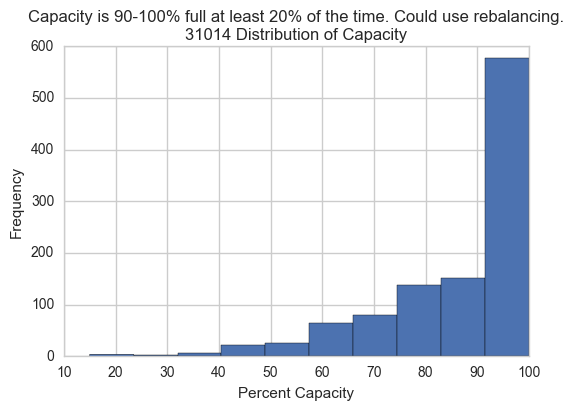

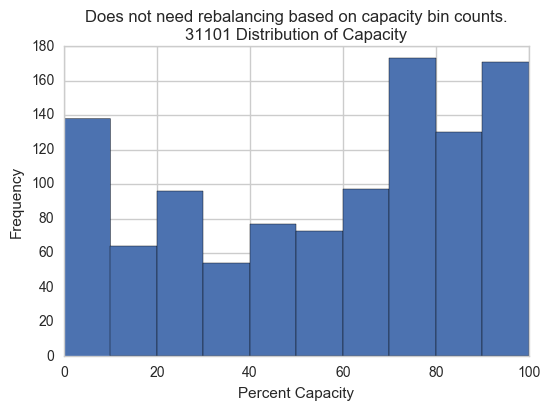

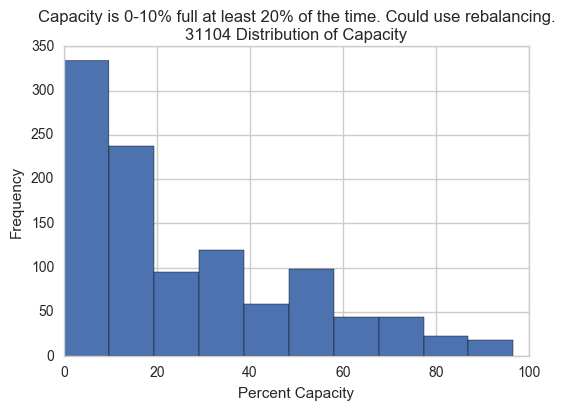

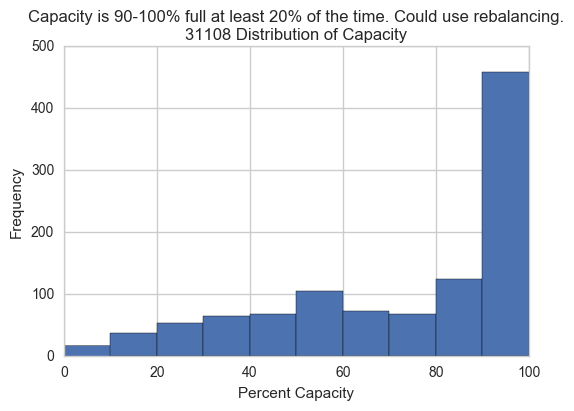

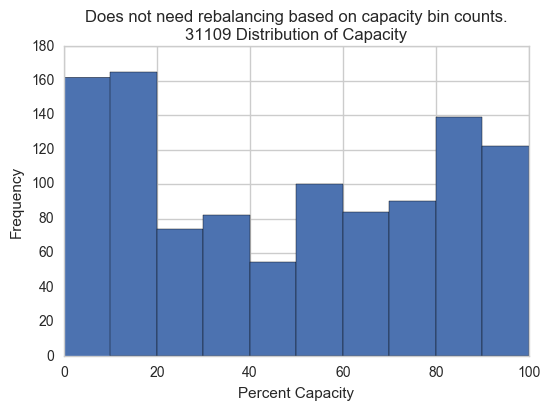

In [48]:
stations_low_high = []
stations_high = []
stations_low = []
stations_normal = []
count = 0 # Display only the first five stations as an example

for station in sorted(list(final_bike_data['Station_Number'].unique())):
    data = final_bike_data[final_bike_data['Station_Number'] == station]
    data = data[int(len(data)*.90):-26]
    
    capacity_bin = pd.cut(data['Count_Percent_Capacity'], include_lowest=True, 
                          bins=[0,10,20,30,40,50,60,70,80,90,100])
    capacity_bin = pd.value_counts(capacity_bin)    
    if (capacity_bin[9]/len(data) > 0.15) and (capacity_bin[0]/len(data) > 0.15):
        description = \
            'Capacity is 90-100% full at least 15% of the time, \n' + \
                'and 0-10% full at least 15% of the time. Could use rebalancing.'
        stations_low_high.append(station)
    elif capacity_bin[9]/len(data) > 0.20:
        description = \
            'Capacity is 90-100% full at least 20% of the time. Could use rebalancing.'
        stations_high.append(station)
    elif capacity_bin[0]/len(data) > 0.20:
        description = \
            'Capacity is 0-10% full at least 20% of the time. Could use rebalancing.'
        stations_low.append(station)
    else:
        description = 'Does not need rebalancing based on capacity bin counts.'
        stations_normal.append(station)
        
    if count < 5:
        pd.DataFrame.hist(data, column='Count_Percent_Capacity')
        plt.title('{}\n{} Distribution of Capacity'.format(description, station))
        plt.ylabel('Frequency')
        plt.xlabel('Percent Capacity')
        plt.show;
        count += 1

In [49]:
# How many stations are in each group?
num_stations = len(final_bike_data['Station_Number'].unique())

print('Percent of low_high stations: {}'\
          .format(round((len(stations_low_high)/num_stations * 100),2)) 
      + '\nNumber of low_high stations: {}'\
          .format(len(stations_low_high)) 
      + '\n\nPercent of high stations: {}'\
          .format(round((len(stations_high)/num_stations * 100),2)) 
      + '\nNumber of high stations: {}'\
          .format(len(stations_high)) 
      + '\n\nPercent of low stations: {}'\
          .format(round((len(stations_low)/num_stations * 100),2)) 
      + '\nNumber of low stations: {}'\
          .format(len(stations_low)) 
      + '\n\nPercent of normal stations: {}'\
          .format(round((len(stations_normal)/num_stations * 100),2))  
      + '\nNumber of normal stations: {}'\
          .format(len(stations_normal)))

# Store the stations that need rebalancing
station_rebalance = stations_low_high + stations_high + stations_low

Percent of low_high stations: 8.96
Number of low_high stations: 6

Percent of high stations: 23.88
Number of high stations: 16

Percent of low stations: 22.39
Number of low stations: 15

Percent of normal stations: 44.78
Number of normal stations: 30


In [50]:
# How many stations need rebalancing?
print('{} stations need rebalancing.'.format(len(station_rebalance)))

37 stations need rebalancing.


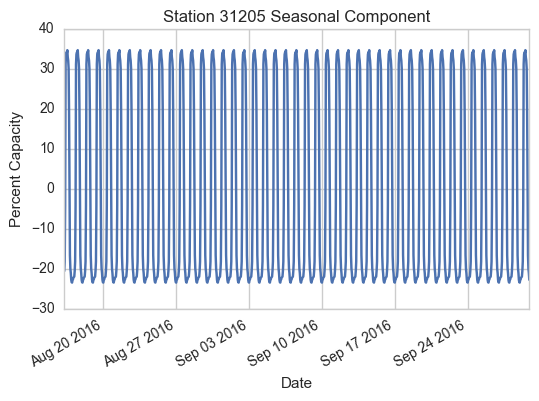

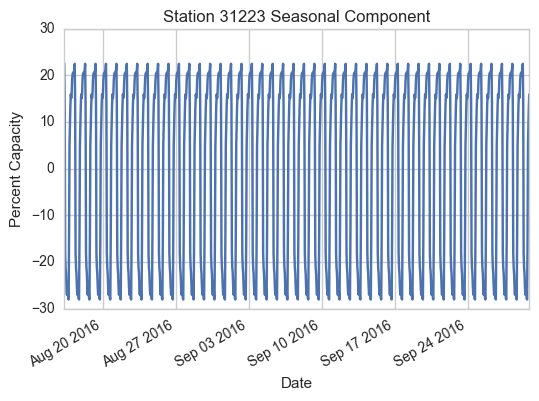

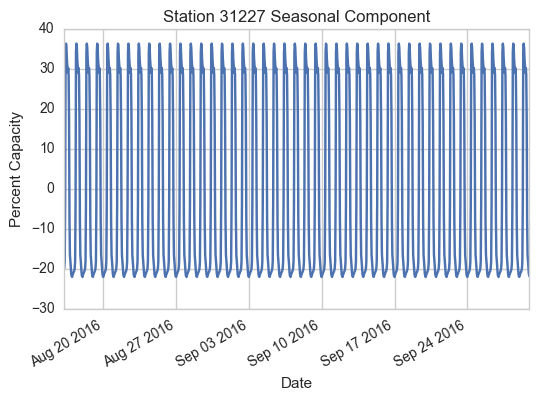

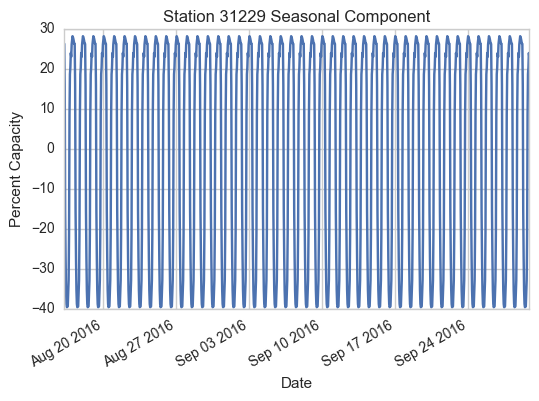

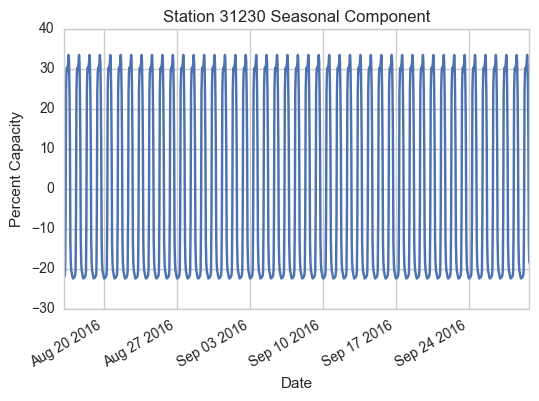

In [51]:
# Does each station exhibit some sort of seasonality?
count = 0 # Display only the first five stations as an example
for station in station_rebalance:
    if count < 5:
        series = final_bike_data[final_bike_data['Station_Number'] == station]
        series = series[int(len(series)*.90):-26]
        series = series[['Date', 'Count_Percent_Capacity']]
        series.set_index('Date', inplace=True)
        series_decomp = seasonal_decompose(series)
        series_decomp.seasonal.plot(legend=None)
        plt.title('Station {} Seasonal Component'.format(station))
        plt.ylabel('Percent Capacity')
        plt.show();
        count += 1

<a id='forecast'></a>  
# Capacity forecast for each station  
Now we know that there are 37 stations that are both popular enough to need rebalancing and exhibit distributions that indicate that rebalancing is needed. Further, each station exhibits some form of seasonality. Below, for each station, I employ Python's version of R's auto.arima function in order to find suitable parameters for inputs into a SARIMA model.  

[Back to Top](#top)

In [52]:
# Define R's auto.arima function
def find_orders(train_start, train_start_plus, train_end, 
                train_end_plus, test_start, test_start_plus, 
                test_end, test_end_plus):
    order_dict = {}
    for station in sorted(station_rebalance):
        df = final_bike_data[final_bike_data['Station_Number'] == station]
        df = df[['Count_Percent_Capacity', 'Date']]
        df.set_index('Date', inplace=True)
        train_df = df[int(len(df)*train_start + \
                          train_start_plus):int(len(df)*train_end + train_end_plus)] 
        test_df = df[int(len(df)*test_start + \
                         test_start_plus):int(len(df)*test_end + test_end_plus)]
        r_data = ts(train_df)
        fit = forecast.auto_arima(r_data, 
                                  d=0, max_p=10, max_q=10, 
                                  start_p=1, start_q=1, 
                                  ic='aic', 
                                  stepwise=False, max_order=15, parallel=True)
        forecast_output = forecast.forecast(fit)

        try:
            p = int(str(forecast_output[0]).lstrip('[1] \"ARIMA')\
                    .rstrip('"\n').split(',')[0].lstrip('('))
            d = int(str(forecast_output[0]).lstrip('[1] \"ARIMA')\
                    .rstrip('"\n').split(',')[1])
            q = int(str(forecast_output[0]).lstrip('[1] \"ARIMA')\
                    .rstrip('"\n').split(',')[2].rstrip(')'))
        except:
            pass

        try:
            p = int(str(forecast_output[0]).lstrip('[1] "ARIMA')\
                    .rstrip(' with non-zero mean\"\n').split(',')[0].lstrip('('))
            d = int(str(forecast_output[0]).lstrip('[1] "ARIMA')\
                    .rstrip(' with non-zero mean\"\n').split(',')[1])
            q = int(str(forecast_output[0]).lstrip('[1] "ARIMA')\
                    .rstrip(' with non-zero mean\"\n').split(',')[2].rstrip(')'))
        except:
            pass

        try:
            p = int(str(forecast_output[0]).lstrip('[1] "ARIMA')\
                    .rstrip(' with drift\"\n').split(',')[0].lstrip('('))
            d = int(str(forecast_output[0]).lstrip('[1] "ARIMA')\
                    .rstrip(' with drift\"\n').split(',')[1])
            q = int(str(forecast_output[0]).lstrip('[1] "ARIMA')\
                    .rstrip(' with drift\"\n').split(',')[2].rstrip(')'))
        except:
            pass

        print('Done: {}; {}'.format(station, [p,d,q]))
        order_dict[station] = [p,d,q, train_df, test_df]
    return order_dict

In [53]:
# For each station: Split the data into train (last ~10% of the data) 
# and test sets (next 24 hours of data), 
# train the model, find the best order, and keep
# the order, train, and testing sets for later use.
# Store the values in a dictionary
order_dict90 = find_orders(0.90,0,0,-26,0,-25,0,-1)

Done: 31014; [5, 0, 0]
Done: 31104; [4, 0, 4]
Done: 31108; [10, 0, 0]
Done: 31114; [2, 0, 8]
Done: 31116; [5, 0, 10]
Done: 31119; [6, 0, 2]
Done: 31121; [5, 0, 3]
Done: 31205; [5, 0, 8]
Done: 31213; [5, 0, 9]
Done: 31214; [10, 0, 2]
Done: 31215; [4, 0, 8]
Done: 31219; [3, 0, 7]
Done: 31223; [6, 0, 8]
Done: 31225; [5, 0, 6]
Done: 31227; [9, 0, 4]
Done: 31228; [8, 0, 3]
Done: 31229; [10, 0, 3]
Done: 31230; [5, 0, 8]
Done: 31231; [2, 0, 5]
Done: 31238; [10, 0, 2]
Done: 31239; [4, 0, 2]
Done: 31241; [9, 0, 3]
Done: 31244; [1, 0, 2]
Done: 31246; [1, 0, 2]
Done: 31258; [1, 0, 4]
Done: 31263; [1, 0, 8]
Done: 31266; [2, 0, 4]
Done: 31269; [1, 0, 2]
Done: 31277; [9, 0, 2]
Done: 31281; [2, 0, 5]
Done: 31600; [5, 0, 2]
Done: 31602; [3, 0, 6]
Done: 31603; [5, 0, 7]
Done: 31613; [2, 0, 0]
Done: 31616; [10, 0, 5]
Done: 31627; [2, 0, 7]
Done: 31628; [4, 0, 9]


In [54]:
# Define a SARIMA function to train, forecast, and plot data
# Show station forecast suggestions
def general_SARIMA(order_dict, station, p_value_dict, model_rating_info):
    
    if station in stations_low_high:
        description = 'Capacity is 90-100% full at least 15% of the time, \n' + \
            'and 0-10% full at least 15% of the time. Could use rebalancing.' 
    elif station in stations_high:
        description = 'Capacity is 90-100% full at least 20% of the time. Could use rebalancing.'
    elif station in stations_low:
        description = 'Capacity is 0-10% full at least 20% of the time. Could use rebalancing.'
    else:
        description = 'Does not need rebalancing.'
            
    X_train = order_dict[station][3]['Count_Percent_Capacity']
    X_test = order_dict[station][4]['Count_Percent_Capacity']

    # Test stationarity
    print('Station {}'.format(station))
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(X_train, autolag='AIC')
    if dftest[0] < dftest[4]['1%']:
        print('We are 99% confident that the series is stationary.\n')
    elif dftest[0] < dftest[4]['5%']:
        print('We are 95% confident that the series is stationary.\n')
    elif dftest[0] < dftest[4]['10%']:
        print('We are 90% confident that the series is stationary.\n')
    else:
        print('We are not confident that the series is stationary.\n')
    p_value_dict[station] = dftest[0]
    
    # SARIMAX Model without exogs
    model = SARIMAX(X_train,
                    enforce_stationarity=False, 
                    enforce_invertibility=False,
                    order=(order_dict[station][0], 
                           order_dict[station][1], 
                           order_dict[station][2]),
                    trend='c')
    results_SARIMAX = model.fit()

    # Plot the forecast
    pred = results_SARIMAX.get_prediction(start=X_train.index[-1], 
                                          end=X_test.index[-1],
                                          dynamic=False)
    pred_ci = pred.conf_int()

    ax = plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)

    ax = X_test.plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Station Capacity')
    plt.title(description, size=10)
    plt.legend()
    
    plt.show()

    # Compute the RMSE
    y_forecasted = pred.predicted_mean
    y_truth = X_test
    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = mse**0.5
    print('RMSE: {:.2f}'.format(rmse))
    print('Order: ({},{},{})'.format(order_dict[station][0], 
                                         order_dict[station][1], 
                                         order_dict[station][2]))
    print('Schedule suggestion: {}'.format(model_rating_info[0]))
    print('Schedule Appropriateness: {}'.format(model_rating_info[1]))
    print('Model Fit: {}'.format(model_rating_info[2]))
    print('Overall model score: {}\n\n'.format(model_rating_info[3]))

For each station, I have made schedule suggestions for the last 24 hours in the dataset and scored both the appropriateness of the schedule and fit of the model to the data, which culminates in a model score. Schedule appropriateness and model fit are judged to be either Poor, Fair, Good, or Very Good. Model score is the addition of each station's qualitative ratings and recorded quantitatively where Poor = 0, Fair = 1, Good = 2, and Very good = 3. For example, a model that happens to cause us to make an appropriate schedule (Very good: 3), but does not seem to follow the observed data very well (Poor: 0) receives a score of 0 + 3 = 3.

Station 31014
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



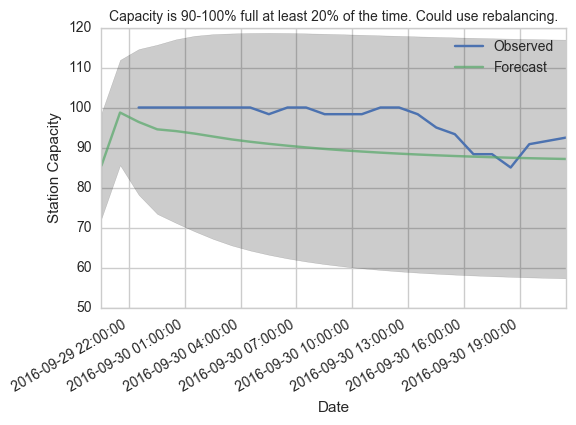

RMSE: 7.38
Order: (5,0,0)
Schedule suggestion: Subtract bikes near the beginning of the period.
Schedule Appropriateness: Good
Model Fit: Good
Overall model score: 4


Station 31104
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


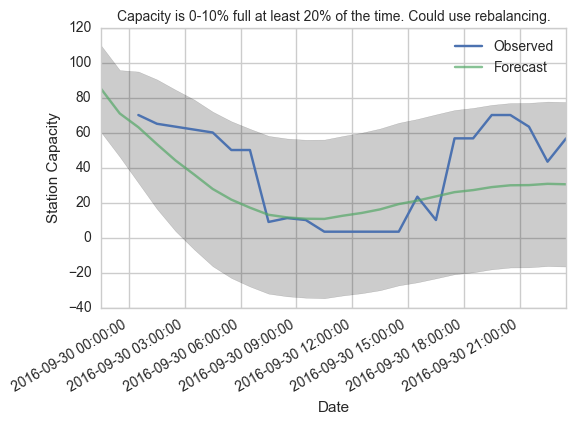

RMSE: 22.46
Order: (4,0,4)
Schedule suggestion: Add bikes around 9am.
Schedule Appropriateness: Very good
Model Fit: Very good
Overall model score: 6


Station 31108
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



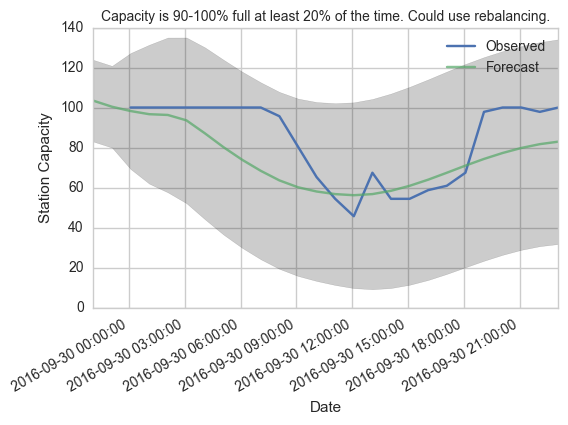

RMSE: 16.09
Order: (10,0,0)
Schedule suggestion: Subtract bikes near the beginning and end of the period.
Schedule Appropriateness: Good
Model Fit: Good
Overall model score: 4


Station 31114
Results of Dickey-Fuller Test:
We are 90% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


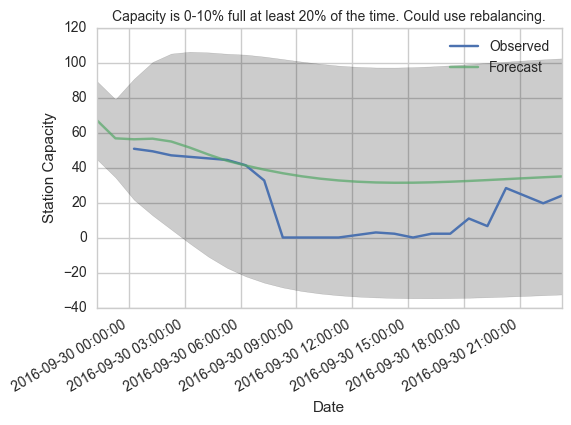

RMSE: 22.29
Order: (2,0,8)
Schedule suggestion: Subtract bikes near the middle of the period.
Schedule Appropriateness: Good
Model Fit: Good
Overall model score: 4


Station 31116
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


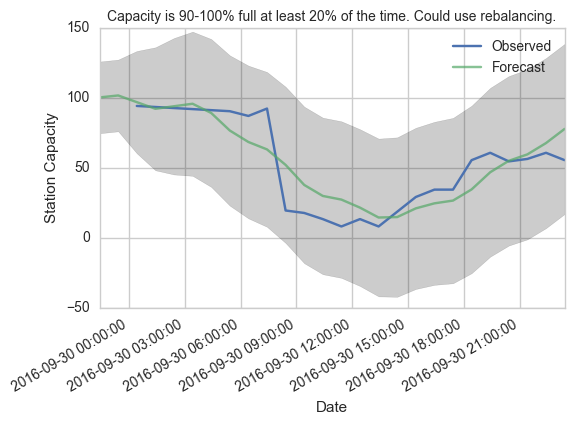

RMSE: 14.51
Order: (5,0,10)
Schedule suggestion: Subtract bikes around midnight.
Schedule Appropriateness: Very good
Model Fit: Very good
Overall model score: 6


Station 31119
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


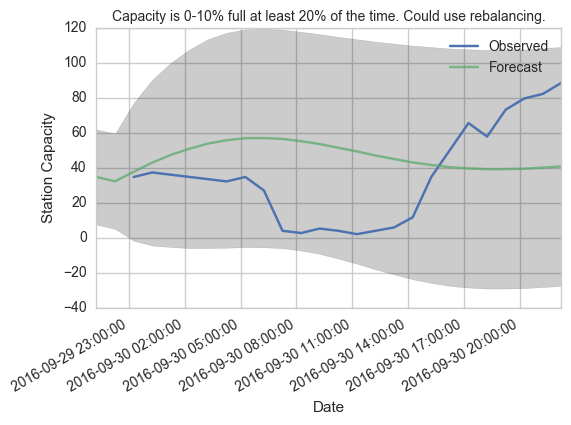

RMSE: 33.83
Order: (6,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Poor
Overall model score: 0


Station 31121
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


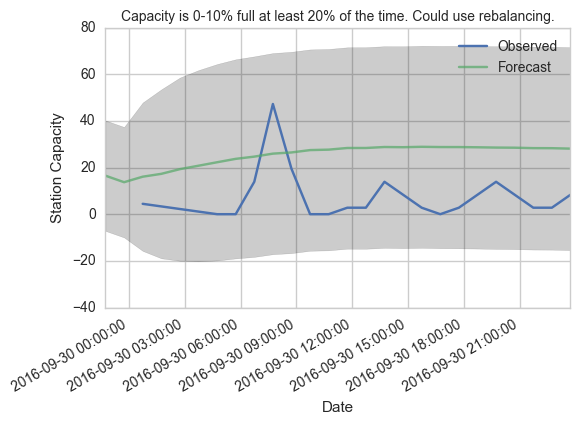

RMSE: 21.47
Order: (5,0,3)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Poor
Overall model score: 0


Station 31205
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


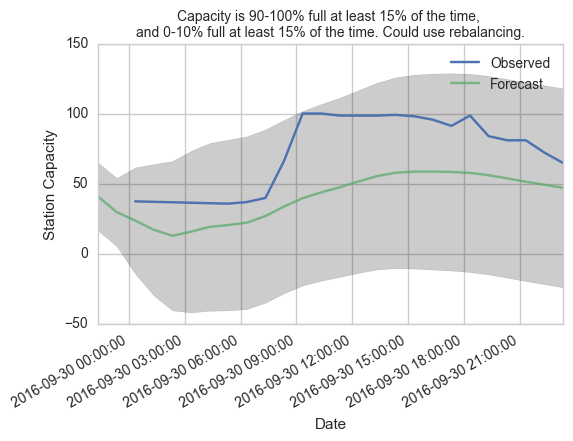

RMSE: 33.99
Order: (5,0,8)
Schedule suggestion: Add bikes around 3am and subtract bikes around 3pm.
Schedule Appropriateness: Fair
Model Fit: Good
Overall model score: 3


Station 31213
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


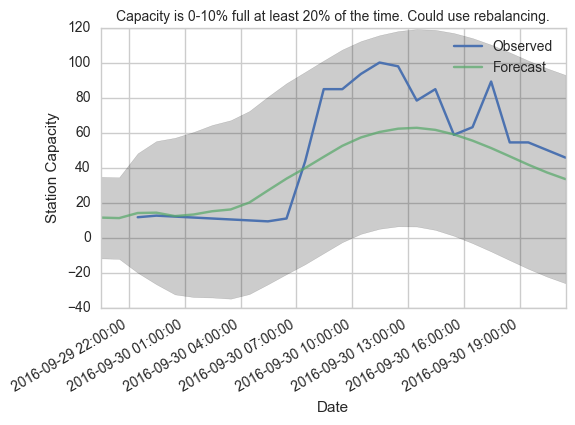

RMSE: 20.96
Order: (5,0,9)
Schedule suggestion: Add bikes near the beginning of the period.
Schedule Appropriateness: Fair
Model Fit: Very good
Overall model score: 4


Station 31214
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


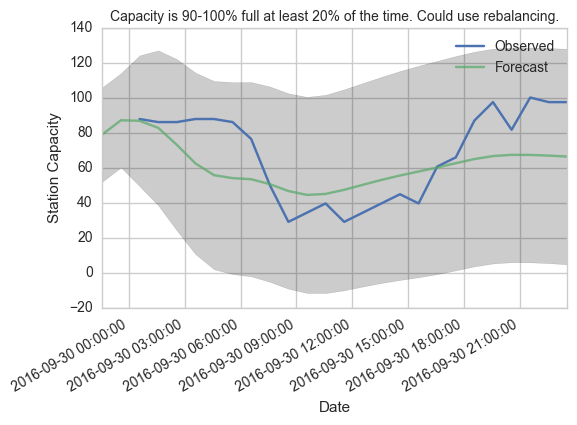

RMSE: 20.10
Order: (10,0,2)
Schedule suggestion: Subtract bikes near the beginning and end of the period.
Schedule Appropriateness: Fair
Model Fit: Good
Overall model score: 3


Station 31215
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


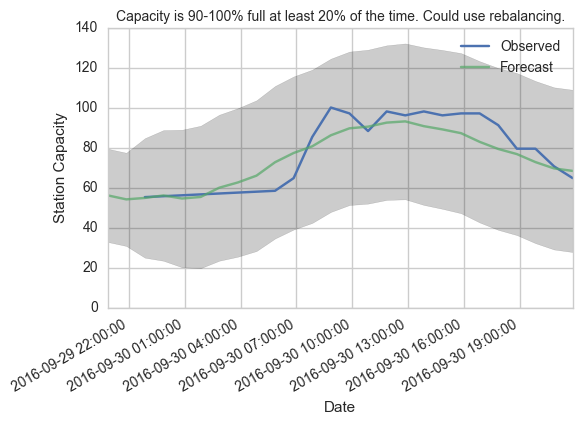

RMSE: 7.61
Order: (4,0,8)
Schedule suggestion: Subtract bikes around 1pm.
Schedule Appropriateness: Very good
Model Fit: Very good
Overall model score: 6


Station 31219
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


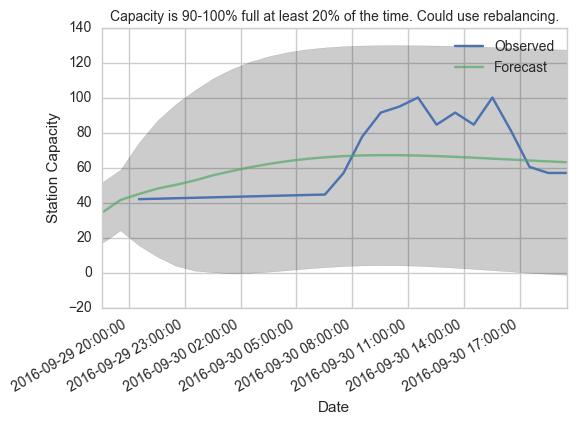

RMSE: 18.29
Order: (3,0,7)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Good
Model Fit: Poor
Overall model score: 2


Station 31223
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


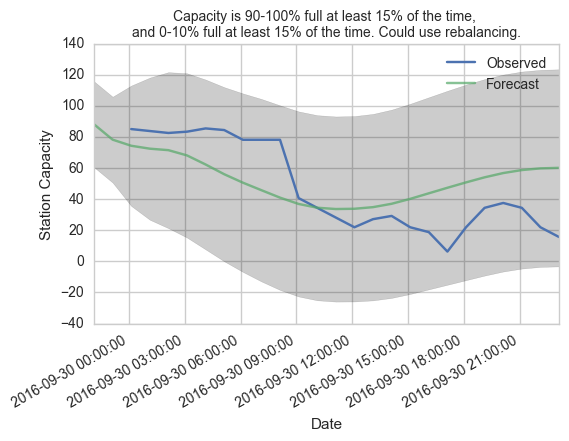

RMSE: 23.86
Order: (6,0,8)
Schedule suggestion: Subtract bikes near the beginning and end of the period.                Add bikes near the middle of the period.
Schedule Appropriateness: Poor
Model Fit: Fair
Overall model score: 1


Station 31225
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


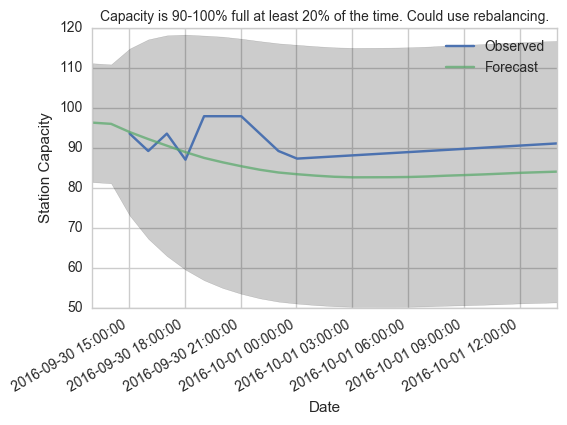

RMSE: 6.74
Order: (5,0,6)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Very good
Model Fit: Very good
Overall model score: 6


Station 31227
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


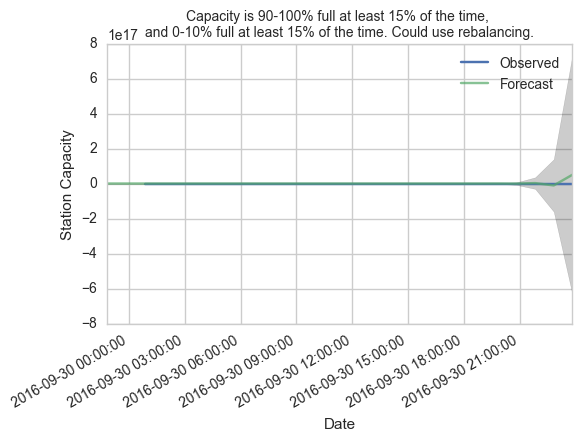

RMSE: 10441437572251792.00
Order: (9,0,4)
Schedule suggestion: No good model.
Schedule Appropriateness: Poor
Model Fit: Poor
Overall model score: 0


Station 31228
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


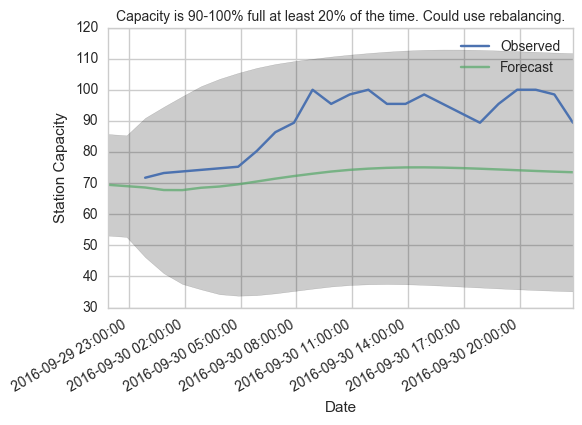

RMSE: 18.51
Order: (8,0,3)
Schedule suggestion: Subtract bikes around 1pm.
Schedule Appropriateness: Good
Model Fit: Poor
Overall model score: 2


Station 31229
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


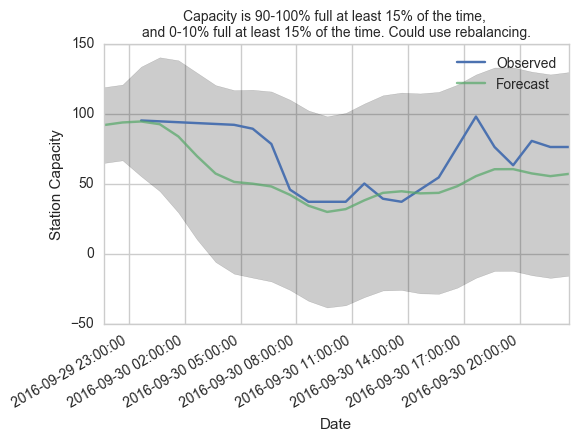

RMSE: 21.10
Order: (10,0,3)
Schedule suggestion: Subtract bikes near the beginning of the period and add                bikes near the middle of the period.
Schedule Appropriateness: Poor
Model Fit: Fair
Overall model score: 1


Station 31230
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


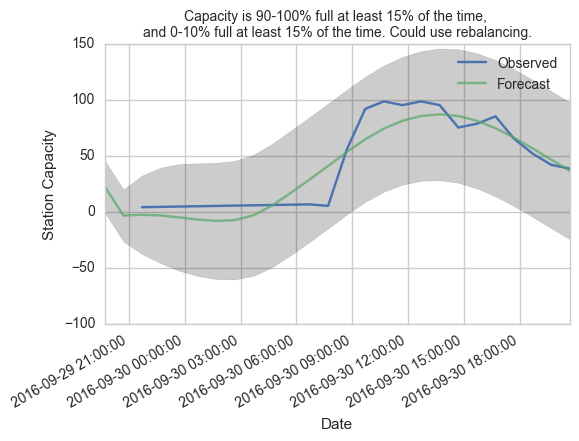

RMSE: 13.96
Order: (5,0,8)
Schedule suggestion: Add bikes around midnight and subtract bikes around 12pm.
Schedule Appropriateness: Very good
Model Fit: Very good
Overall model score: 6


Station 31231
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


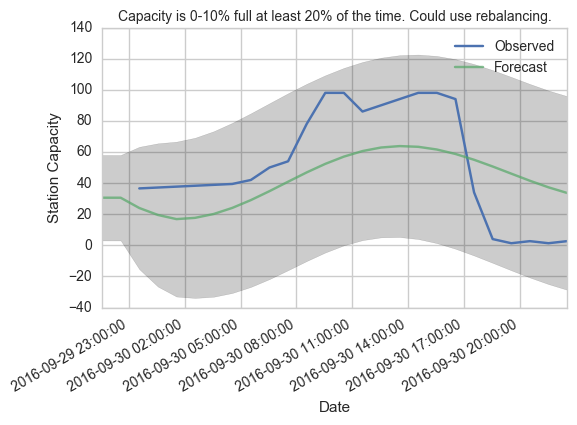

RMSE: 30.05
Order: (2,0,5)
Schedule suggestion: Add bikes around 2am and subtracts bikes around 11am.
Schedule Appropriateness: Poor
Model Fit: Good
Overall model score: 2


Station 31238
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


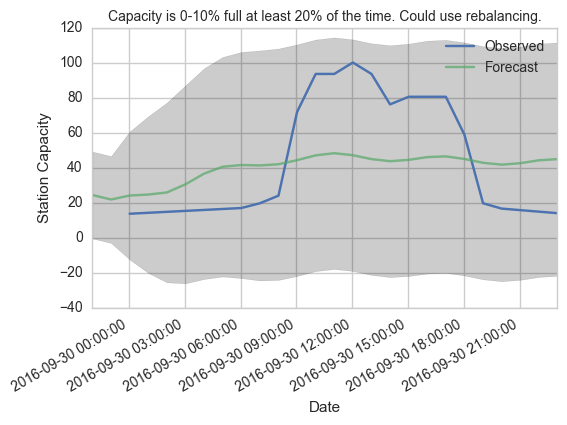

RMSE: 30.08
Order: (10,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Very good
Model Fit: Poor
Overall model score: 3


Station 31239
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


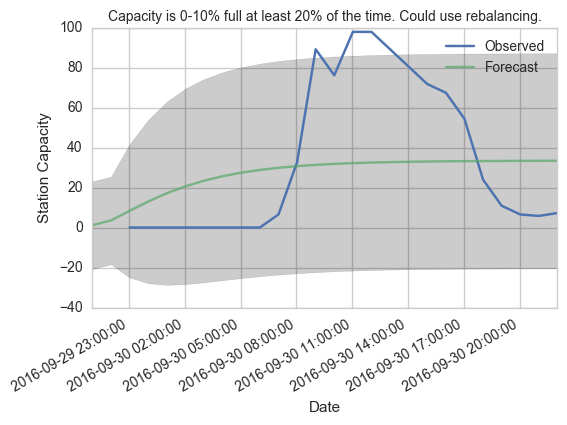

RMSE: 35.05
Order: (4,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Poor
Overall model score: 0


Station 31241
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


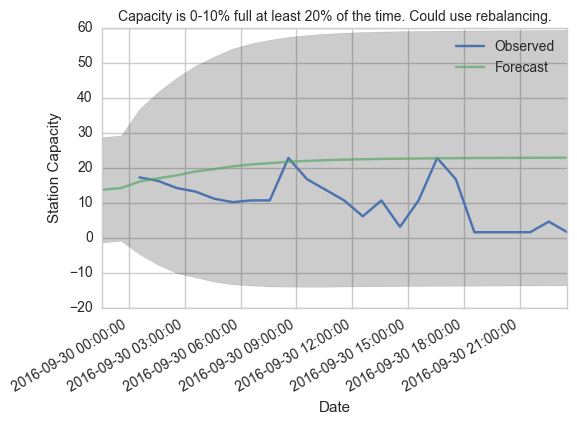

RMSE: 13.28
Order: (9,0,3)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Good
Model Fit: Fair
Overall model score: 3


Station 31244
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



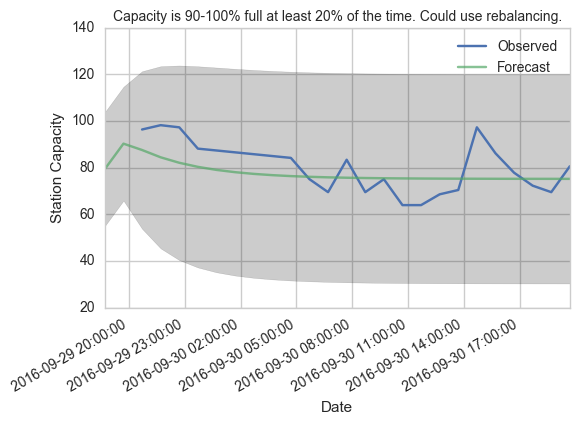

RMSE: 9.24
Order: (1,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Very good
Model Fit: Good
Overall model score: 5


Station 31246
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



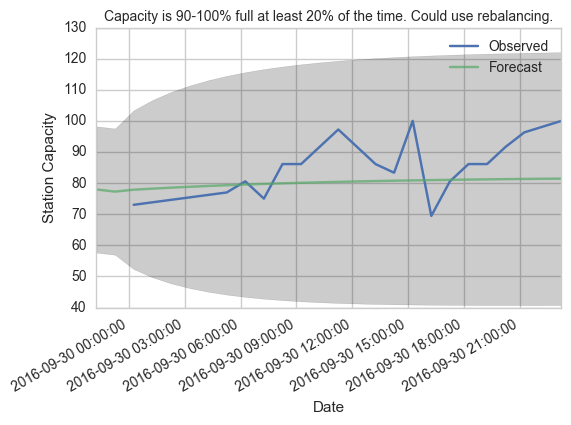

RMSE: 9.71
Order: (1,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Good
Model Fit: Fair
Overall model score: 3


Station 31258
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



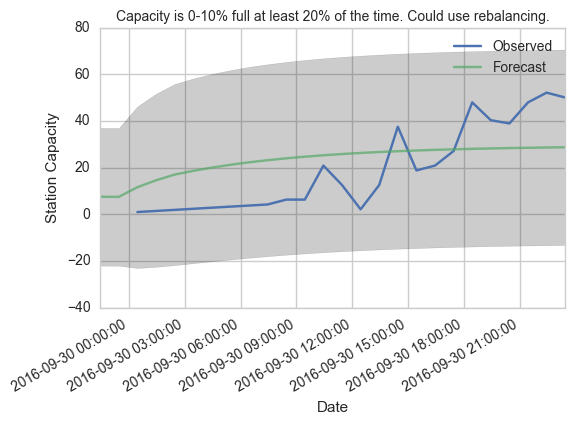

RMSE: 15.81
Order: (1,0,4)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Fair
Model Fit: Good
Overall model score: 3


Station 31263
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



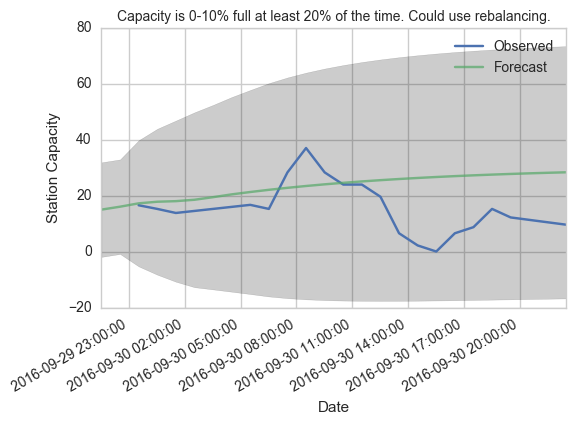

RMSE: 13.18
Order: (1,0,8)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Very good
Model Fit: Fair
Overall model score: 4


Station 31266
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


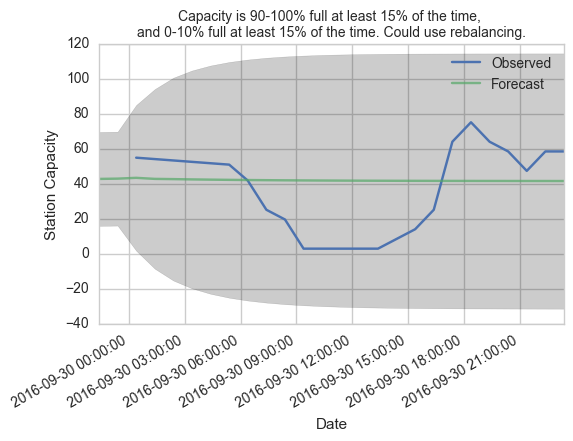

RMSE: 24.28
Order: (2,0,4)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Poor
Overall model score: 0


Station 31269
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



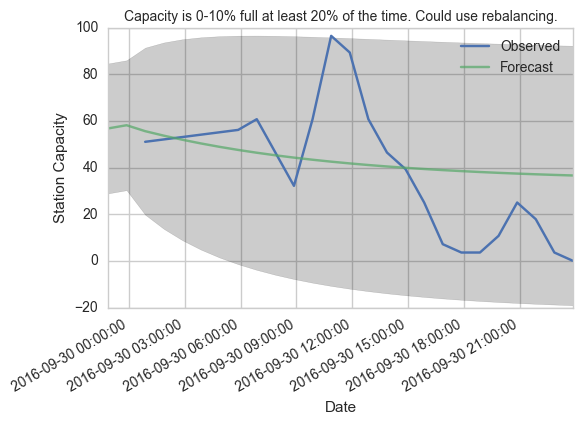

RMSE: 23.91
Order: (1,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Good
Model Fit: Poor
Overall model score: 2


Station 31277
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


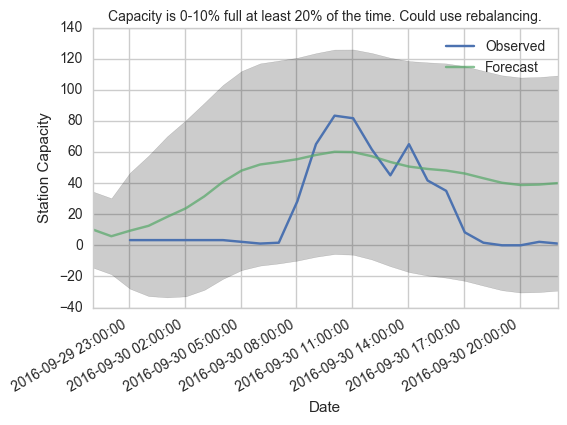

RMSE: 30.13
Order: (9,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Good
Overall model score: 2


Station 31281
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


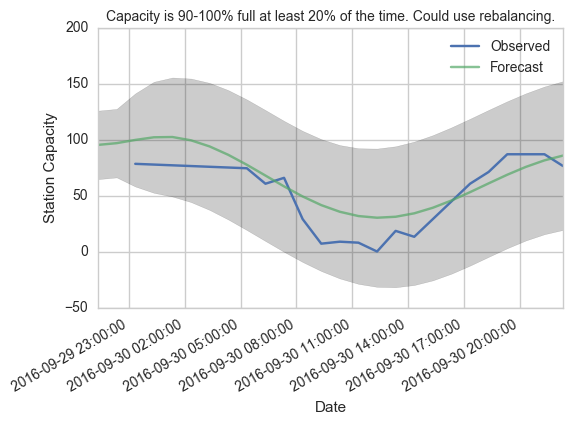

RMSE: 18.28
Order: (2,0,5)
Schedule suggestion: Subtract bikes around 2am and 8pm.
Schedule Appropriateness: Poor
Model Fit: Very good
Overall model score: 3


Station 31600
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


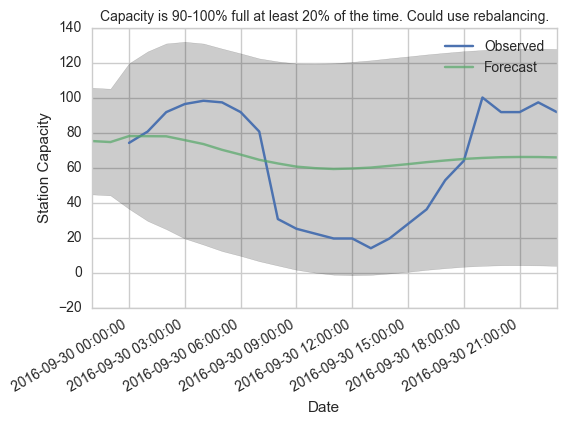

RMSE: 28.66
Order: (5,0,2)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Good
Model Fit: Poor
Overall model score: 2


Station 31602
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


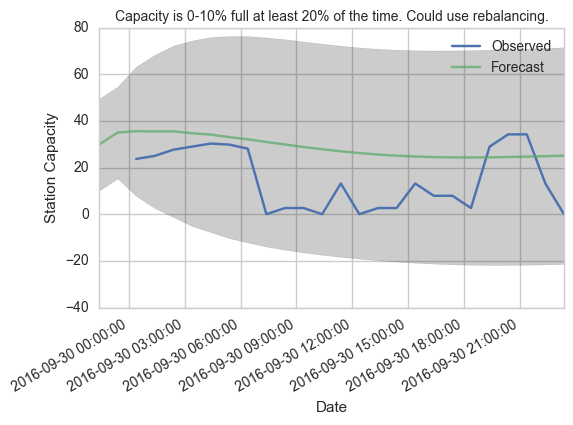

RMSE: 17.77
Order: (3,0,6)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Poor
Overall model score: 0


Station 31603
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


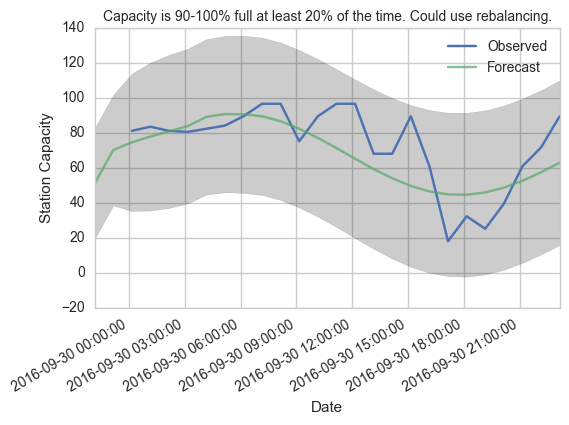

RMSE: 16.56
Order: (5,0,7)
Schedule suggestion: Subtract bikes around 6am.
Schedule Appropriateness: Good
Model Fit: Very good
Overall model score: 5


Station 31613
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



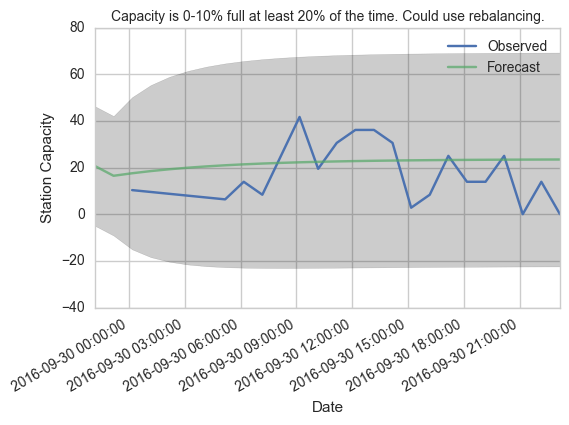

RMSE: 12.72
Order: (2,0,0)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Fair
Model Fit: Fair
Overall model score: 2


Station 31616
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


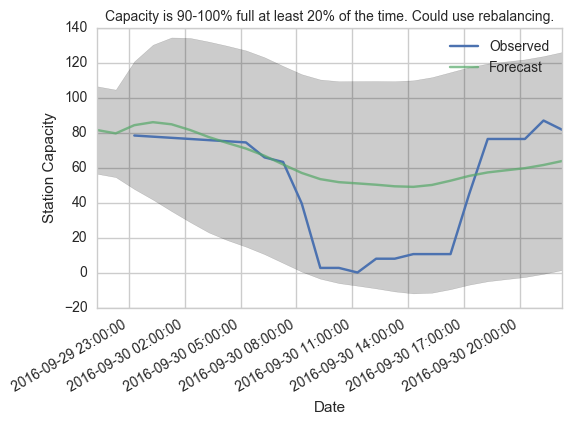

RMSE: 27.70
Order: (10,0,5)
Schedule suggestion: Subtract bikes around 2am.
Schedule Appropriateness: Poor
Model Fit: Fair
Overall model score: 1


Station 31627
Results of Dickey-Fuller Test:
We are 99% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


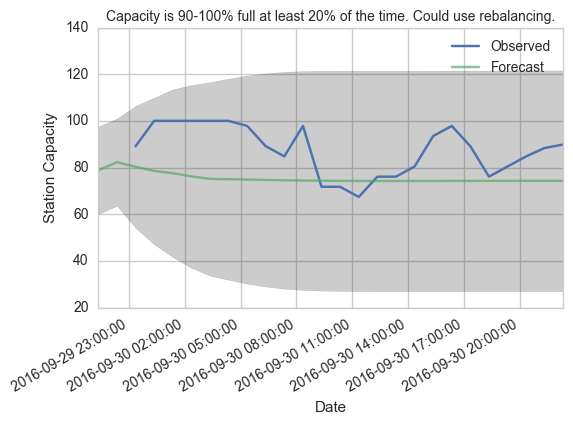

RMSE: 15.93
Order: (2,0,7)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Poor
Model Fit: Fair
Overall model score: 1


Station 31628
Results of Dickey-Fuller Test:
We are 95% confident that the series is stationary.



/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


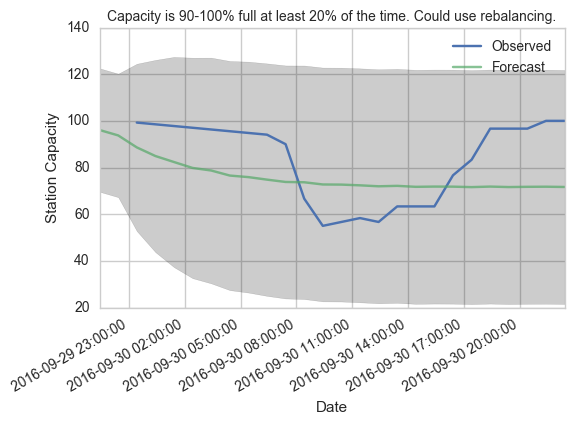

RMSE: 17.55
Order: (4,0,9)
Schedule suggestion: No need for rebalancing.
Schedule Appropriateness: Good
Model Fit: Fair
Overall model score: 3




In [55]:
# Store all model schedules and scores in a dictionary
model_score = {31014: ['Subtract bikes near the beginning of the period.', 
                       'Good', 'Good', 4],
               31104: ['Add bikes around 9am.', 
                       'Very good', 'Very good', 6],
               31108: ['Subtract bikes near the beginning and end of the period.', 
                       'Good', 'Good', 4],
               31114: ['Subtract bikes near the middle of the period.', 
                       'Good', 'Good', 4],
               31116: ['Subtract bikes around midnight.', 
                       'Very good', 'Very good', 6],
               31119: ['No need for rebalancing.', 
                       'Poor', 'Poor', 0],
               31121: ['No need for rebalancing.', 
                       'Poor', 'Poor', 0],
               31205: ['Add bikes around 3am and subtract bikes around 3pm.', 
                       'Fair', 'Good', 3],
               31213: ['Add bikes near the beginning of the period.', 
                       'Fair', 'Very good', 4],
               31214: ['Subtract bikes near the beginning and end of the period.', 
                       'Fair', 'Good', 3],
               31215: ['Subtract bikes around 1pm.', 
                       'Very good', 'Very good', 6],
               31219: ['No need for rebalancing.', 
                       'Good', 'Poor', 2],
               31223: ['Subtract bikes near the beginning and end of the period. \
               Add bikes near the middle of the period.', 'Poor', 'Fair', 1],
               31225: ['No need for rebalancing.', 'Very good', 'Very good', 6],
               31227: ['No good model.', 'Poor', 'Poor', 0],
               31228: ['Subtract bikes around 1pm.', 'Good', 'Poor', 2],
               31229: ['Subtract bikes near the beginning of the period and add \
               bikes near the middle of the period.', 'Poor', 'Fair', 1],
               31230: ['Add bikes around midnight and subtract bikes around 12pm.', 
                       'Very good', 'Very good', 6],
               31231: ['Add bikes around 2am and subtracts bikes around 11am.', 
                       'Poor', 'Good', 2],
               31238: ['No need for rebalancing.', 'Very good', 'Poor', 3],
               31239: ['No need for rebalancing.', 'Poor', 'Poor', 0],
               31241: ['No need for rebalancing.', 'Good', 'Fair', 3],
               31244: ['No need for rebalancing.', 'Very good', 'Good', 5],
               31246: ['No need for rebalancing.', 'Good', 'Fair', 3],
               31258: ['No need for rebalancing.', 'Fair', 'Good', 3],
               31263: ['No need for rebalancing.', 'Very good', 'Fair', 4],
               31266: ['No need for rebalancing.', 'Poor', 'Poor', 0],
               31269: ['No need for rebalancing.', 'Good', 'Poor', 2],
               31277: ['No need for rebalancing.', 'Poor', 'Good', 2],
               31281: ['Subtract bikes around 2am and 8pm.', 'Poor', 'Very good', 3],
               31600: ['No need for rebalancing.', 'Good', 'Poor', 2],
               31602: ['No need for rebalancing.', 'Poor', 'Poor', 0],
               31603: ['Subtract bikes around 6am.', 'Good', 'Very good', 5],
               31613: ['No need for rebalancing.', 'Fair', 'Fair', 2],
               31616: ['Subtract bikes around 2am.', 'Poor', 'Fair', 1],
               31627: ['No need for rebalancing.', 'Poor', 'Fair', 1],
               31628: ['No need for rebalancing.', 'Good', 'Fair', 3]}

# For each station: Train a SARIMA model, 
# plot the forecast against the test set,
# record RMSE, and output suggested schedule
# and model scores
p_value_dict90 = {}
for station in sorted(list(order_dict90.keys())):
    general_SARIMA(order_dict90, station, p_value_dict90, model_score[station])

Lastly, let's get a feel for how many usable models we have and how usable they are:

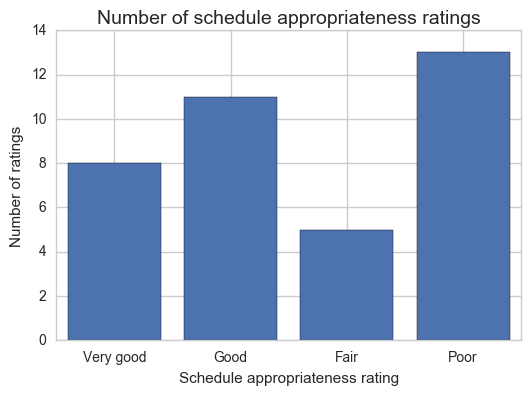

In [56]:
# How does schedule appropriateness look for each station?
qual_labels = ['Very good', 'Good', 'Fair', 'Poor']
schedule_qual = [8,11,5,13]
schedule_pos = np.arange(len(schedule_qual))

plt.bar(schedule_pos, schedule_qual, align='center')
plt.xticks(schedule_pos, qual_labels)
plt.title('Number of schedule appropriateness ratings', size=14)
plt.ylabel('Number of ratings')
plt.xlabel('Schedule appropriateness rating')
plt.show;

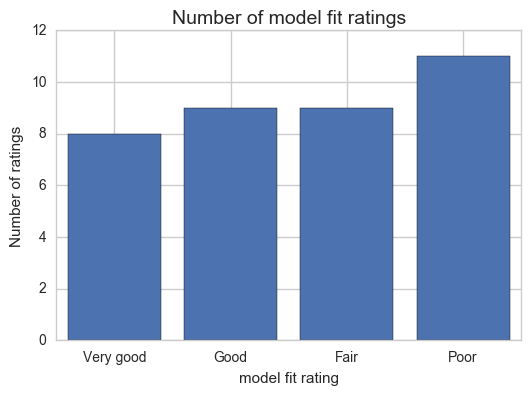

In [57]:
# How does model fit look for each station?
forecast_qual = [8,9,9,11]

plt.bar(schedule_pos, forecast_qual, align='center')
plt.xticks(schedule_pos, qual_labels)
plt.title('Number of model fit ratings', size=14)
plt.ylabel('Number of ratings')
plt.xlabel('model fit rating')
plt.show;

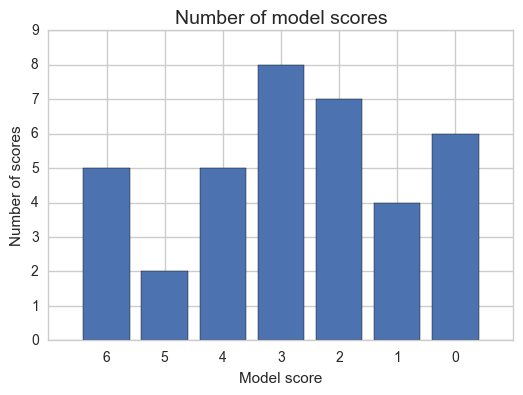

In [58]:
# How does model score look for each station?
score_labels = ['6','5','4','3','2','1','0']
model_scores = [5,2,5,8,7,4,6]
model_pos = np.arange(len(score_labels))

plt.bar(model_pos, model_scores, align='center')
plt.xticks(model_pos, score_labels)
plt.title('Number of model scores', size=14)
plt.ylabel('Number of scores')
plt.xlabel('Model score')
plt.ylim(0,9)
plt.show;